# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

If there are any questions, please contact mlta-2022-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [2]:
!nvidia-smi

Fri Jun  3 03:20:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Download dataset
!wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files
!unzip real_or_drawing.zip

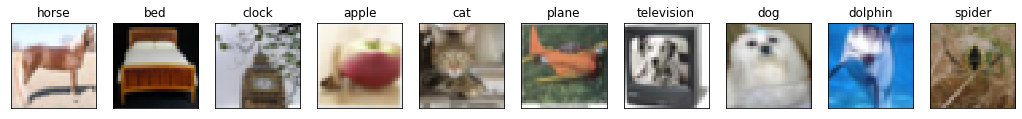

In [4]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

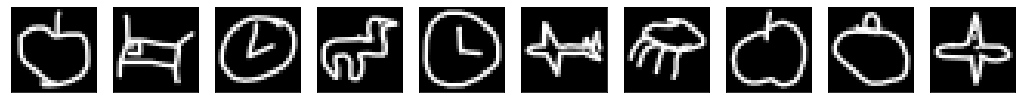

In [5]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


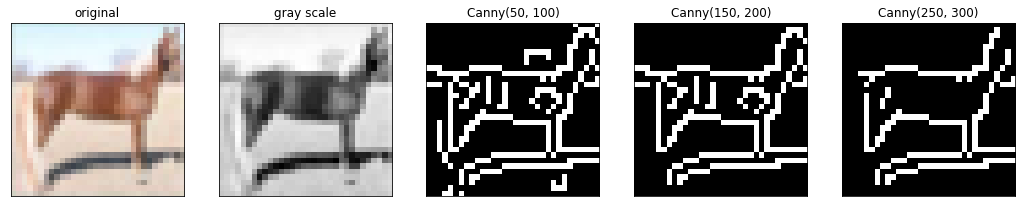

In [6]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
 
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
 
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
 
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [8]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [9]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

lr = 5e-4
optimizer_F = optim.AdamW(feature_extractor.parameters(), lr=lr)
optimizer_C = optim.AdamW(label_predictor.parameters(), lr=lr)
optimizer_D = optim.AdamW(domain_classifier.parameters(), lr=lr)

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [10]:
from tqdm import tqdm
import math

In [11]:
num_epoch = 1000
def lamb_scheduler(epoch, num_epoch=num_epoch):
    return 2.5/(1+ math.exp(-10*((epoch+1)/num_epoch)))-1

In [12]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')
    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

for epoch in tqdm(range(num_epoch)):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=lamb_scheduler(epoch))

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')
    if epoch % 100 == 0:
      torch.save(feature_extractor.state_dict(), f'extractor_model_{epoch}.bin')
      torch.save(label_predictor.state_dict(), f'predictor_model_{epoch}.bin')
    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:09<2:30:02,  9.01s/it]

epoch   0: train D loss: 0.6613, train F loss: 2.0846, acc 0.1436


  0%|          | 2/1000 [00:17<2:24:13,  8.67s/it]

epoch   1: train D loss: 0.6023, train F loss: 1.9872, acc 0.1752


  0%|          | 3/1000 [00:25<2:22:05,  8.55s/it]

epoch   2: train D loss: 0.6967, train F loss: 1.8103, acc 0.2414


  0%|          | 4/1000 [00:34<2:21:06,  8.50s/it]

epoch   3: train D loss: 0.6897, train F loss: 1.7251, acc 0.2892


  0%|          | 5/1000 [00:42<2:20:02,  8.44s/it]

epoch   4: train D loss: 0.6800, train F loss: 1.6324, acc 0.3278


  1%|          | 6/1000 [00:50<2:19:31,  8.42s/it]

epoch   5: train D loss: 0.6862, train F loss: 1.5171, acc 0.3708


  1%|          | 7/1000 [00:59<2:19:08,  8.41s/it]

epoch   6: train D loss: 0.6728, train F loss: 1.4162, acc 0.4260


  1%|          | 8/1000 [01:07<2:18:45,  8.39s/it]

epoch   7: train D loss: 0.6701, train F loss: 1.3390, acc 0.4542


  1%|          | 9/1000 [01:16<2:19:31,  8.45s/it]

epoch   8: train D loss: 0.6704, train F loss: 1.3056, acc 0.4706


  1%|          | 10/1000 [01:24<2:19:13,  8.44s/it]

epoch   9: train D loss: 0.6623, train F loss: 1.2664, acc 0.4786


  1%|          | 11/1000 [01:33<2:18:58,  8.43s/it]

epoch  10: train D loss: 0.6743, train F loss: 1.2148, acc 0.5002


  1%|          | 12/1000 [01:41<2:18:42,  8.42s/it]

epoch  11: train D loss: 0.6757, train F loss: 1.1770, acc 0.5102


  1%|▏         | 13/1000 [01:49<2:18:35,  8.42s/it]

epoch  12: train D loss: 0.6702, train F loss: 1.1584, acc 0.5116


  1%|▏         | 14/1000 [01:58<2:18:35,  8.43s/it]

epoch  13: train D loss: 0.6752, train F loss: 1.1290, acc 0.5290


  2%|▏         | 15/1000 [02:06<2:18:22,  8.43s/it]

epoch  14: train D loss: 0.6754, train F loss: 1.0910, acc 0.5414


  2%|▏         | 16/1000 [02:15<2:17:52,  8.41s/it]

epoch  15: train D loss: 0.6756, train F loss: 1.0595, acc 0.5492


  2%|▏         | 17/1000 [02:23<2:17:31,  8.39s/it]

epoch  16: train D loss: 0.6774, train F loss: 1.0244, acc 0.5652


  2%|▏         | 18/1000 [02:32<2:17:47,  8.42s/it]

epoch  17: train D loss: 0.6758, train F loss: 1.0043, acc 0.5658


  2%|▏         | 19/1000 [02:40<2:17:51,  8.43s/it]

epoch  18: train D loss: 0.6764, train F loss: 0.9627, acc 0.5820


  2%|▏         | 20/1000 [02:49<2:19:21,  8.53s/it]

epoch  19: train D loss: 0.6799, train F loss: 0.9458, acc 0.5900


  2%|▏         | 21/1000 [02:57<2:18:22,  8.48s/it]

epoch  20: train D loss: 0.6797, train F loss: 0.9358, acc 0.5940


  2%|▏         | 22/1000 [03:06<2:17:53,  8.46s/it]

epoch  21: train D loss: 0.6794, train F loss: 0.9081, acc 0.5978


  2%|▏         | 23/1000 [03:14<2:17:26,  8.44s/it]

epoch  22: train D loss: 0.6793, train F loss: 0.8633, acc 0.6120


  2%|▏         | 24/1000 [03:22<2:17:00,  8.42s/it]

epoch  23: train D loss: 0.6830, train F loss: 0.8583, acc 0.6176


  2%|▎         | 25/1000 [03:31<2:17:01,  8.43s/it]

epoch  24: train D loss: 0.6843, train F loss: 0.8276, acc 0.6180


  3%|▎         | 26/1000 [03:39<2:16:49,  8.43s/it]

epoch  25: train D loss: 0.6829, train F loss: 0.8061, acc 0.6224


  3%|▎         | 27/1000 [03:48<2:16:25,  8.41s/it]

epoch  26: train D loss: 0.6846, train F loss: 0.7785, acc 0.6400


  3%|▎         | 28/1000 [03:56<2:16:00,  8.40s/it]

epoch  27: train D loss: 0.6827, train F loss: 0.7716, acc 0.6376


  3%|▎         | 29/1000 [04:04<2:15:54,  8.40s/it]

epoch  28: train D loss: 0.6848, train F loss: 0.7379, acc 0.6488


  3%|▎         | 30/1000 [04:13<2:16:05,  8.42s/it]

epoch  29: train D loss: 0.6839, train F loss: 0.7052, acc 0.6556


  3%|▎         | 31/1000 [04:21<2:16:03,  8.42s/it]

epoch  30: train D loss: 0.6833, train F loss: 0.6888, acc 0.6654


  3%|▎         | 32/1000 [04:30<2:15:51,  8.42s/it]

epoch  31: train D loss: 0.6888, train F loss: 0.6814, acc 0.6622


  3%|▎         | 33/1000 [04:38<2:15:14,  8.39s/it]

epoch  32: train D loss: 0.6847, train F loss: 0.6438, acc 0.6780


  3%|▎         | 34/1000 [04:46<2:15:06,  8.39s/it]

epoch  33: train D loss: 0.6857, train F loss: 0.6094, acc 0.6856


  4%|▎         | 35/1000 [04:55<2:14:56,  8.39s/it]

epoch  34: train D loss: 0.6849, train F loss: 0.5924, acc 0.6880


  4%|▎         | 36/1000 [05:03<2:14:48,  8.39s/it]

epoch  35: train D loss: 0.6853, train F loss: 0.5732, acc 0.6886


  4%|▎         | 37/1000 [05:11<2:14:16,  8.37s/it]

epoch  36: train D loss: 0.6817, train F loss: 0.5221, acc 0.7110


  4%|▍         | 38/1000 [05:20<2:14:00,  8.36s/it]

epoch  37: train D loss: 0.6825, train F loss: 0.5333, acc 0.7042


  4%|▍         | 39/1000 [05:28<2:13:54,  8.36s/it]

epoch  38: train D loss: 0.6876, train F loss: 0.4846, acc 0.7244


  4%|▍         | 40/1000 [05:36<2:13:28,  8.34s/it]

epoch  39: train D loss: 0.6860, train F loss: 0.4786, acc 0.7176


  4%|▍         | 41/1000 [05:45<2:13:20,  8.34s/it]

epoch  40: train D loss: 0.6855, train F loss: 0.4415, acc 0.7346


  4%|▍         | 42/1000 [05:53<2:12:51,  8.32s/it]

epoch  41: train D loss: 0.6843, train F loss: 0.4097, acc 0.7444


  4%|▍         | 43/1000 [06:01<2:12:41,  8.32s/it]

epoch  42: train D loss: 0.6848, train F loss: 0.3921, acc 0.7466


  4%|▍         | 44/1000 [06:10<2:12:23,  8.31s/it]

epoch  43: train D loss: 0.6846, train F loss: 0.3968, acc 0.7452


  4%|▍         | 45/1000 [06:18<2:12:10,  8.30s/it]

epoch  44: train D loss: 0.6844, train F loss: 0.3529, acc 0.7558


  5%|▍         | 46/1000 [06:26<2:12:10,  8.31s/it]

epoch  45: train D loss: 0.6842, train F loss: 0.3376, acc 0.7656


  5%|▍         | 47/1000 [06:35<2:12:07,  8.32s/it]

epoch  46: train D loss: 0.6852, train F loss: 0.3118, acc 0.7686


  5%|▍         | 48/1000 [06:43<2:12:08,  8.33s/it]

epoch  47: train D loss: 0.6858, train F loss: 0.3143, acc 0.7706


  5%|▍         | 49/1000 [06:51<2:12:09,  8.34s/it]

epoch  48: train D loss: 0.6849, train F loss: 0.2908, acc 0.7718


  5%|▌         | 50/1000 [07:00<2:11:47,  8.32s/it]

epoch  49: train D loss: 0.6823, train F loss: 0.2519, acc 0.7876


  5%|▌         | 51/1000 [07:08<2:11:28,  8.31s/it]

epoch  50: train D loss: 0.6869, train F loss: 0.2293, acc 0.7966


  5%|▌         | 52/1000 [07:16<2:11:41,  8.34s/it]

epoch  51: train D loss: 0.6856, train F loss: 0.1935, acc 0.8040


  5%|▌         | 53/1000 [07:25<2:11:31,  8.33s/it]

epoch  52: train D loss: 0.6878, train F loss: 0.1832, acc 0.8022


  5%|▌         | 54/1000 [07:33<2:11:31,  8.34s/it]

epoch  53: train D loss: 0.6861, train F loss: 0.1590, acc 0.8118


  6%|▌         | 55/1000 [07:41<2:11:10,  8.33s/it]

epoch  54: train D loss: 0.6863, train F loss: 0.1400, acc 0.8202


  6%|▌         | 56/1000 [07:50<2:10:55,  8.32s/it]

epoch  55: train D loss: 0.6846, train F loss: 0.1038, acc 0.8270


  6%|▌         | 57/1000 [07:58<2:10:44,  8.32s/it]

epoch  56: train D loss: 0.6860, train F loss: 0.1203, acc 0.8224


  6%|▌         | 58/1000 [08:06<2:10:36,  8.32s/it]

epoch  57: train D loss: 0.6841, train F loss: 0.0869, acc 0.8334


  6%|▌         | 59/1000 [08:15<2:10:30,  8.32s/it]

epoch  58: train D loss: 0.6860, train F loss: 0.0677, acc 0.8386


  6%|▌         | 60/1000 [08:23<2:10:23,  8.32s/it]

epoch  59: train D loss: 0.6870, train F loss: 0.0576, acc 0.8354


  6%|▌         | 61/1000 [08:31<2:09:59,  8.31s/it]

epoch  60: train D loss: 0.6808, train F loss: 0.0210, acc 0.8552


  6%|▌         | 62/1000 [08:39<2:09:37,  8.29s/it]

epoch  61: train D loss: 0.6863, train F loss: 0.0224, acc 0.8496


  6%|▋         | 63/1000 [08:48<2:09:29,  8.29s/it]

epoch  62: train D loss: 0.6857, train F loss: -0.0278, acc 0.8646


  6%|▋         | 64/1000 [08:56<2:09:29,  8.30s/it]

epoch  63: train D loss: 0.6850, train F loss: 0.0030, acc 0.8578


  6%|▋         | 65/1000 [09:04<2:09:31,  8.31s/it]

epoch  64: train D loss: 0.6871, train F loss: -0.0088, acc 0.8550


  7%|▋         | 66/1000 [09:13<2:09:06,  8.29s/it]

epoch  65: train D loss: 0.6865, train F loss: -0.0393, acc 0.8714


  7%|▋         | 67/1000 [09:21<2:08:59,  8.30s/it]

epoch  66: train D loss: 0.6840, train F loss: -0.0609, acc 0.8734


  7%|▋         | 68/1000 [09:29<2:09:01,  8.31s/it]

epoch  67: train D loss: 0.6825, train F loss: -0.0831, acc 0.8746


  7%|▋         | 69/1000 [09:38<2:08:44,  8.30s/it]

epoch  68: train D loss: 0.6808, train F loss: -0.0813, acc 0.8788


  7%|▋         | 70/1000 [09:46<2:08:38,  8.30s/it]

epoch  69: train D loss: 0.6836, train F loss: -0.1046, acc 0.8868


  7%|▋         | 71/1000 [09:54<2:08:15,  8.28s/it]

epoch  70: train D loss: 0.6839, train F loss: -0.0731, acc 0.8714


  7%|▋         | 72/1000 [10:02<2:08:36,  8.32s/it]

epoch  71: train D loss: 0.6846, train F loss: -0.1156, acc 0.8840


  7%|▋         | 73/1000 [10:11<2:08:34,  8.32s/it]

epoch  72: train D loss: 0.6875, train F loss: -0.1480, acc 0.8956


  7%|▋         | 74/1000 [10:19<2:08:22,  8.32s/it]

epoch  73: train D loss: 0.6814, train F loss: -0.1365, acc 0.8908


  8%|▊         | 75/1000 [10:27<2:07:58,  8.30s/it]

epoch  74: train D loss: 0.6818, train F loss: -0.1453, acc 0.8932


  8%|▊         | 76/1000 [10:36<2:08:14,  8.33s/it]

epoch  75: train D loss: 0.6823, train F loss: -0.1772, acc 0.8998


  8%|▊         | 77/1000 [10:44<2:08:15,  8.34s/it]

epoch  76: train D loss: 0.6833, train F loss: -0.1672, acc 0.9024


  8%|▊         | 78/1000 [10:52<2:08:01,  8.33s/it]

epoch  77: train D loss: 0.6815, train F loss: -0.2100, acc 0.9076


  8%|▊         | 79/1000 [11:01<2:07:30,  8.31s/it]

epoch  78: train D loss: 0.6865, train F loss: -0.2107, acc 0.9112


  8%|▊         | 80/1000 [11:09<2:07:18,  8.30s/it]

epoch  79: train D loss: 0.6832, train F loss: -0.2209, acc 0.9118


  8%|▊         | 81/1000 [11:17<2:07:11,  8.30s/it]

epoch  80: train D loss: 0.6814, train F loss: -0.2178, acc 0.9056


  8%|▊         | 82/1000 [11:26<2:06:59,  8.30s/it]

epoch  81: train D loss: 0.6865, train F loss: -0.2254, acc 0.9108


  8%|▊         | 83/1000 [11:34<2:06:56,  8.31s/it]

epoch  82: train D loss: 0.6816, train F loss: -0.2469, acc 0.9142


  8%|▊         | 84/1000 [11:42<2:06:39,  8.30s/it]

epoch  83: train D loss: 0.6835, train F loss: -0.2552, acc 0.9176


  8%|▊         | 85/1000 [11:50<2:06:19,  8.28s/it]

epoch  84: train D loss: 0.6863, train F loss: -0.2424, acc 0.9104


  9%|▊         | 86/1000 [11:59<2:06:12,  8.29s/it]

epoch  85: train D loss: 0.6868, train F loss: -0.2644, acc 0.9176


  9%|▊         | 87/1000 [12:07<2:06:12,  8.29s/it]

epoch  86: train D loss: 0.6811, train F loss: -0.2656, acc 0.9214


  9%|▉         | 88/1000 [12:15<2:06:21,  8.31s/it]

epoch  87: train D loss: 0.6841, train F loss: -0.2940, acc 0.9232


  9%|▉         | 89/1000 [12:24<2:06:12,  8.31s/it]

epoch  88: train D loss: 0.6796, train F loss: -0.3024, acc 0.9300


  9%|▉         | 90/1000 [12:32<2:05:53,  8.30s/it]

epoch  89: train D loss: 0.6853, train F loss: -0.3078, acc 0.9310


  9%|▉         | 91/1000 [12:40<2:05:45,  8.30s/it]

epoch  90: train D loss: 0.6847, train F loss: -0.2907, acc 0.9184


  9%|▉         | 92/1000 [12:49<2:05:32,  8.30s/it]

epoch  91: train D loss: 0.6828, train F loss: -0.3125, acc 0.9286


  9%|▉         | 93/1000 [12:57<2:05:24,  8.30s/it]

epoch  92: train D loss: 0.6848, train F loss: -0.3337, acc 0.9302


  9%|▉         | 94/1000 [13:05<2:05:08,  8.29s/it]

epoch  93: train D loss: 0.6841, train F loss: -0.3110, acc 0.9270


 10%|▉         | 95/1000 [13:13<2:05:01,  8.29s/it]

epoch  94: train D loss: 0.6837, train F loss: -0.3405, acc 0.9316


 10%|▉         | 96/1000 [13:22<2:04:52,  8.29s/it]

epoch  95: train D loss: 0.6854, train F loss: -0.3406, acc 0.9320


 10%|▉         | 97/1000 [13:30<2:04:46,  8.29s/it]

epoch  96: train D loss: 0.6826, train F loss: -0.3443, acc 0.9300


 10%|▉         | 98/1000 [13:38<2:04:33,  8.29s/it]

epoch  97: train D loss: 0.6832, train F loss: -0.3570, acc 0.9348


 10%|▉         | 99/1000 [13:47<2:04:28,  8.29s/it]

epoch  98: train D loss: 0.6820, train F loss: -0.3391, acc 0.9292


 10%|█         | 100/1000 [13:55<2:04:20,  8.29s/it]

epoch  99: train D loss: 0.6826, train F loss: -0.3884, acc 0.9480


 10%|█         | 101/1000 [14:03<2:04:18,  8.30s/it]

epoch 100: train D loss: 0.6817, train F loss: -0.3493, acc 0.9282


 10%|█         | 102/1000 [14:11<2:04:15,  8.30s/it]

epoch 101: train D loss: 0.6834, train F loss: -0.3838, acc 0.9400


 10%|█         | 103/1000 [14:20<2:03:57,  8.29s/it]

epoch 102: train D loss: 0.6827, train F loss: -0.3774, acc 0.9392


 10%|█         | 104/1000 [14:28<2:04:00,  8.30s/it]

epoch 103: train D loss: 0.6835, train F loss: -0.4020, acc 0.9430


 10%|█         | 105/1000 [14:36<2:03:55,  8.31s/it]

epoch 104: train D loss: 0.6847, train F loss: -0.4053, acc 0.9454


 11%|█         | 106/1000 [14:45<2:03:41,  8.30s/it]

epoch 105: train D loss: 0.6829, train F loss: -0.4055, acc 0.9444


 11%|█         | 107/1000 [14:53<2:03:44,  8.31s/it]

epoch 106: train D loss: 0.6832, train F loss: -0.4159, acc 0.9456


 11%|█         | 108/1000 [15:01<2:03:32,  8.31s/it]

epoch 107: train D loss: 0.6837, train F loss: -0.4081, acc 0.9380


 11%|█         | 109/1000 [15:10<2:03:13,  8.30s/it]

epoch 108: train D loss: 0.6829, train F loss: -0.4201, acc 0.9452


 11%|█         | 110/1000 [15:18<2:03:23,  8.32s/it]

epoch 109: train D loss: 0.6843, train F loss: -0.4025, acc 0.9400


 11%|█         | 111/1000 [15:26<2:03:07,  8.31s/it]

epoch 110: train D loss: 0.6826, train F loss: -0.4025, acc 0.9344


 11%|█         | 112/1000 [15:35<2:02:59,  8.31s/it]

epoch 111: train D loss: 0.6839, train F loss: -0.4464, acc 0.9480


 11%|█▏        | 113/1000 [15:43<2:02:35,  8.29s/it]

epoch 112: train D loss: 0.6876, train F loss: -0.4372, acc 0.9414


 11%|█▏        | 114/1000 [15:51<2:02:25,  8.29s/it]

epoch 113: train D loss: 0.6815, train F loss: -0.4392, acc 0.9448


 12%|█▏        | 115/1000 [15:59<2:02:21,  8.30s/it]

epoch 114: train D loss: 0.6808, train F loss: -0.4466, acc 0.9462


 12%|█▏        | 116/1000 [16:08<2:02:03,  8.28s/it]

epoch 115: train D loss: 0.6854, train F loss: -0.4530, acc 0.9440


 12%|█▏        | 117/1000 [16:16<2:01:56,  8.29s/it]

epoch 116: train D loss: 0.6814, train F loss: -0.4656, acc 0.9452


 12%|█▏        | 118/1000 [16:24<2:01:52,  8.29s/it]

epoch 117: train D loss: 0.6813, train F loss: -0.4574, acc 0.9520


 12%|█▏        | 119/1000 [16:33<2:01:38,  8.28s/it]

epoch 118: train D loss: 0.6833, train F loss: -0.4521, acc 0.9436


 12%|█▏        | 120/1000 [16:41<2:01:22,  8.28s/it]

epoch 119: train D loss: 0.6855, train F loss: -0.4828, acc 0.9510


 12%|█▏        | 121/1000 [16:49<2:01:14,  8.28s/it]

epoch 120: train D loss: 0.6819, train F loss: -0.4502, acc 0.9416


 12%|█▏        | 122/1000 [16:57<2:01:05,  8.28s/it]

epoch 121: train D loss: 0.6834, train F loss: -0.4938, acc 0.9560


 12%|█▏        | 123/1000 [17:06<2:00:44,  8.26s/it]

epoch 122: train D loss: 0.6834, train F loss: -0.4928, acc 0.9514


 12%|█▏        | 124/1000 [17:14<2:00:39,  8.26s/it]

epoch 123: train D loss: 0.6809, train F loss: -0.4759, acc 0.9456


 12%|█▎        | 125/1000 [17:22<2:00:44,  8.28s/it]

epoch 124: train D loss: 0.6822, train F loss: -0.5121, acc 0.9580


 13%|█▎        | 126/1000 [17:30<2:00:41,  8.29s/it]

epoch 125: train D loss: 0.6817, train F loss: -0.4916, acc 0.9478


 13%|█▎        | 127/1000 [17:39<2:00:33,  8.29s/it]

epoch 126: train D loss: 0.6822, train F loss: -0.5011, acc 0.9494


 13%|█▎        | 128/1000 [17:47<2:00:17,  8.28s/it]

epoch 127: train D loss: 0.6820, train F loss: -0.5163, acc 0.9550


 13%|█▎        | 129/1000 [17:55<2:00:14,  8.28s/it]

epoch 128: train D loss: 0.6857, train F loss: -0.5108, acc 0.9528


 13%|█▎        | 130/1000 [18:04<1:59:59,  8.28s/it]

epoch 129: train D loss: 0.6819, train F loss: -0.5140, acc 0.9570


 13%|█▎        | 131/1000 [18:12<1:59:46,  8.27s/it]

epoch 130: train D loss: 0.6811, train F loss: -0.5175, acc 0.9542


 13%|█▎        | 132/1000 [18:20<1:59:38,  8.27s/it]

epoch 131: train D loss: 0.6833, train F loss: -0.4954, acc 0.9480


 13%|█▎        | 133/1000 [18:28<1:59:44,  8.29s/it]

epoch 132: train D loss: 0.6842, train F loss: -0.5343, acc 0.9550


 13%|█▎        | 134/1000 [18:37<1:59:46,  8.30s/it]

epoch 133: train D loss: 0.6812, train F loss: -0.5245, acc 0.9546


 14%|█▎        | 135/1000 [18:45<1:59:19,  8.28s/it]

epoch 134: train D loss: 0.6810, train F loss: -0.5522, acc 0.9644


 14%|█▎        | 136/1000 [18:53<1:59:11,  8.28s/it]

epoch 135: train D loss: 0.6853, train F loss: -0.5278, acc 0.9514


 14%|█▎        | 137/1000 [19:01<1:59:01,  8.28s/it]

epoch 136: train D loss: 0.6803, train F loss: -0.5613, acc 0.9626


 14%|█▍        | 138/1000 [19:10<1:58:37,  8.26s/it]

epoch 137: train D loss: 0.6846, train F loss: -0.5460, acc 0.9550


 14%|█▍        | 139/1000 [19:18<1:58:21,  8.25s/it]

epoch 138: train D loss: 0.6858, train F loss: -0.5766, acc 0.9656


 14%|█▍        | 140/1000 [19:26<1:58:23,  8.26s/it]

epoch 139: train D loss: 0.6795, train F loss: -0.5457, acc 0.9558


 14%|█▍        | 141/1000 [19:35<1:58:29,  8.28s/it]

epoch 140: train D loss: 0.6852, train F loss: -0.5741, acc 0.9630


 14%|█▍        | 142/1000 [19:43<1:58:08,  8.26s/it]

epoch 141: train D loss: 0.6852, train F loss: -0.5156, acc 0.9466


 14%|█▍        | 143/1000 [19:51<1:57:52,  8.25s/it]

epoch 142: train D loss: 0.6843, train F loss: -0.5642, acc 0.9582


 14%|█▍        | 144/1000 [19:59<1:57:38,  8.25s/it]

epoch 143: train D loss: 0.6839, train F loss: -0.5770, acc 0.9594


 14%|█▍        | 145/1000 [20:07<1:57:32,  8.25s/it]

epoch 144: train D loss: 0.6840, train F loss: -0.5498, acc 0.9510


 15%|█▍        | 146/1000 [20:16<1:57:19,  8.24s/it]

epoch 145: train D loss: 0.6833, train F loss: -0.5876, acc 0.9634


 15%|█▍        | 147/1000 [20:24<1:57:34,  8.27s/it]

epoch 146: train D loss: 0.6839, train F loss: -0.5662, acc 0.9554


 15%|█▍        | 148/1000 [20:32<1:57:44,  8.29s/it]

epoch 147: train D loss: 0.6831, train F loss: -0.5723, acc 0.9600


 15%|█▍        | 149/1000 [20:41<2:00:33,  8.50s/it]

epoch 148: train D loss: 0.6889, train F loss: -0.5843, acc 0.9560


 15%|█▌        | 150/1000 [20:51<2:04:35,  8.79s/it]

epoch 149: train D loss: 0.6786, train F loss: -0.5856, acc 0.9618


 15%|█▌        | 151/1000 [20:59<2:02:23,  8.65s/it]

epoch 150: train D loss: 0.6846, train F loss: -0.5968, acc 0.9636


 15%|█▌        | 152/1000 [21:07<2:00:39,  8.54s/it]

epoch 151: train D loss: 0.6801, train F loss: -0.6081, acc 0.9656


 15%|█▌        | 153/1000 [21:16<1:59:16,  8.45s/it]

epoch 152: train D loss: 0.6852, train F loss: -0.5993, acc 0.9614


 15%|█▌        | 154/1000 [21:24<1:58:41,  8.42s/it]

epoch 153: train D loss: 0.6812, train F loss: -0.6114, acc 0.9658


 16%|█▌        | 155/1000 [21:32<1:57:49,  8.37s/it]

epoch 154: train D loss: 0.6833, train F loss: -0.6011, acc 0.9582


 16%|█▌        | 156/1000 [21:41<1:57:15,  8.34s/it]

epoch 155: train D loss: 0.6852, train F loss: -0.6036, acc 0.9608


 16%|█▌        | 157/1000 [21:49<1:56:55,  8.32s/it]

epoch 156: train D loss: 0.6854, train F loss: -0.6174, acc 0.9648


 16%|█▌        | 158/1000 [21:57<1:56:40,  8.31s/it]

epoch 157: train D loss: 0.6862, train F loss: -0.6000, acc 0.9568


 16%|█▌        | 159/1000 [22:05<1:56:23,  8.30s/it]

epoch 158: train D loss: 0.6829, train F loss: -0.6162, acc 0.9638


 16%|█▌        | 160/1000 [22:14<1:56:12,  8.30s/it]

epoch 159: train D loss: 0.6828, train F loss: -0.6254, acc 0.9642


 16%|█▌        | 161/1000 [22:22<1:55:53,  8.29s/it]

epoch 160: train D loss: 0.6848, train F loss: -0.6213, acc 0.9616


 16%|█▌        | 162/1000 [22:30<1:55:51,  8.29s/it]

epoch 161: train D loss: 0.6837, train F loss: -0.6353, acc 0.9672


 16%|█▋        | 163/1000 [22:39<1:55:36,  8.29s/it]

epoch 162: train D loss: 0.6825, train F loss: -0.6314, acc 0.9652


 16%|█▋        | 164/1000 [22:47<1:55:37,  8.30s/it]

epoch 163: train D loss: 0.6830, train F loss: -0.6244, acc 0.9636


 16%|█▋        | 165/1000 [22:55<1:55:25,  8.29s/it]

epoch 164: train D loss: 0.6849, train F loss: -0.6353, acc 0.9622


 17%|█▋        | 166/1000 [23:03<1:55:16,  8.29s/it]

epoch 165: train D loss: 0.6841, train F loss: -0.6453, acc 0.9682


 17%|█▋        | 167/1000 [23:12<1:55:02,  8.29s/it]

epoch 166: train D loss: 0.6823, train F loss: -0.6372, acc 0.9670


 17%|█▋        | 168/1000 [23:20<1:54:54,  8.29s/it]

epoch 167: train D loss: 0.6846, train F loss: -0.6343, acc 0.9618


 17%|█▋        | 169/1000 [23:28<1:54:44,  8.28s/it]

epoch 168: train D loss: 0.6815, train F loss: -0.6557, acc 0.9690


 17%|█▋        | 170/1000 [23:37<1:54:39,  8.29s/it]

epoch 169: train D loss: 0.6845, train F loss: -0.6388, acc 0.9622


 17%|█▋        | 171/1000 [23:45<1:54:28,  8.29s/it]

epoch 170: train D loss: 0.6827, train F loss: -0.6596, acc 0.9656


 17%|█▋        | 172/1000 [23:53<1:54:11,  8.28s/it]

epoch 171: train D loss: 0.6833, train F loss: -0.6517, acc 0.9670


 17%|█▋        | 173/1000 [24:01<1:54:02,  8.27s/it]

epoch 172: train D loss: 0.6843, train F loss: -0.6629, acc 0.9668


 17%|█▋        | 174/1000 [24:10<1:53:53,  8.27s/it]

epoch 173: train D loss: 0.6837, train F loss: -0.6536, acc 0.9670


 18%|█▊        | 175/1000 [24:18<1:53:56,  8.29s/it]

epoch 174: train D loss: 0.6828, train F loss: -0.6640, acc 0.9678


 18%|█▊        | 176/1000 [24:26<1:53:44,  8.28s/it]

epoch 175: train D loss: 0.6846, train F loss: -0.6722, acc 0.9676


 18%|█▊        | 177/1000 [24:35<1:53:39,  8.29s/it]

epoch 176: train D loss: 0.6839, train F loss: -0.6736, acc 0.9680


 18%|█▊        | 178/1000 [24:43<1:53:19,  8.27s/it]

epoch 177: train D loss: 0.6862, train F loss: -0.6549, acc 0.9624


 18%|█▊        | 179/1000 [24:51<1:53:06,  8.27s/it]

epoch 178: train D loss: 0.6798, train F loss: -0.6726, acc 0.9672


 18%|█▊        | 180/1000 [24:59<1:52:56,  8.26s/it]

epoch 179: train D loss: 0.6883, train F loss: -0.6687, acc 0.9648


 18%|█▊        | 181/1000 [25:08<1:52:50,  8.27s/it]

epoch 180: train D loss: 0.6848, train F loss: -0.6993, acc 0.9724


 18%|█▊        | 182/1000 [25:16<1:52:47,  8.27s/it]

epoch 181: train D loss: 0.6822, train F loss: -0.6750, acc 0.9662


 18%|█▊        | 183/1000 [25:24<1:52:57,  8.30s/it]

epoch 182: train D loss: 0.6860, train F loss: -0.6950, acc 0.9696


 18%|█▊        | 184/1000 [25:33<1:52:55,  8.30s/it]

epoch 183: train D loss: 0.6840, train F loss: -0.6939, acc 0.9706


 18%|█▊        | 185/1000 [25:41<1:53:04,  8.32s/it]

epoch 184: train D loss: 0.6836, train F loss: -0.6921, acc 0.9660


 19%|█▊        | 186/1000 [25:49<1:52:42,  8.31s/it]

epoch 185: train D loss: 0.6853, train F loss: -0.6902, acc 0.9658


 19%|█▊        | 187/1000 [25:57<1:52:21,  8.29s/it]

epoch 186: train D loss: 0.6846, train F loss: -0.7020, acc 0.9696


 19%|█▉        | 188/1000 [26:06<1:52:08,  8.29s/it]

epoch 187: train D loss: 0.6895, train F loss: -0.6755, acc 0.9590


 19%|█▉        | 189/1000 [26:14<1:51:55,  8.28s/it]

epoch 188: train D loss: 0.6871, train F loss: -0.7007, acc 0.9696


 19%|█▉        | 190/1000 [26:22<1:51:46,  8.28s/it]

epoch 189: train D loss: 0.6857, train F loss: -0.7186, acc 0.9732


 19%|█▉        | 191/1000 [26:30<1:51:27,  8.27s/it]

epoch 190: train D loss: 0.6853, train F loss: -0.7074, acc 0.9710


 19%|█▉        | 192/1000 [26:39<1:51:17,  8.26s/it]

epoch 191: train D loss: 0.6814, train F loss: -0.7164, acc 0.9746


 19%|█▉        | 193/1000 [26:47<1:51:21,  8.28s/it]

epoch 192: train D loss: 0.6888, train F loss: -0.7209, acc 0.9680


 19%|█▉        | 194/1000 [26:55<1:51:20,  8.29s/it]

epoch 193: train D loss: 0.6839, train F loss: -0.7076, acc 0.9712


 20%|█▉        | 195/1000 [27:04<1:51:14,  8.29s/it]

epoch 194: train D loss: 0.6861, train F loss: -0.6842, acc 0.9616


 20%|█▉        | 196/1000 [27:12<1:51:03,  8.29s/it]

epoch 195: train D loss: 0.6846, train F loss: -0.7085, acc 0.9636


 20%|█▉        | 197/1000 [27:20<1:50:52,  8.29s/it]

epoch 196: train D loss: 0.6841, train F loss: -0.7229, acc 0.9722


 20%|█▉        | 198/1000 [27:28<1:50:38,  8.28s/it]

epoch 197: train D loss: 0.6823, train F loss: -0.7345, acc 0.9724


 20%|█▉        | 199/1000 [27:37<1:50:25,  8.27s/it]

epoch 198: train D loss: 0.6852, train F loss: -0.7327, acc 0.9744


 20%|██        | 200/1000 [27:45<1:50:21,  8.28s/it]

epoch 199: train D loss: 0.6848, train F loss: -0.7218, acc 0.9666


 20%|██        | 201/1000 [27:53<1:50:16,  8.28s/it]

epoch 200: train D loss: 0.6831, train F loss: -0.7313, acc 0.9722


 20%|██        | 202/1000 [28:02<1:50:19,  8.29s/it]

epoch 201: train D loss: 0.6866, train F loss: -0.7299, acc 0.9704


 20%|██        | 203/1000 [28:10<1:50:17,  8.30s/it]

epoch 202: train D loss: 0.6860, train F loss: -0.7310, acc 0.9702


 20%|██        | 204/1000 [28:18<1:50:01,  8.29s/it]

epoch 203: train D loss: 0.6811, train F loss: -0.7441, acc 0.9724


 20%|██        | 205/1000 [28:27<1:49:49,  8.29s/it]

epoch 204: train D loss: 0.6862, train F loss: -0.7428, acc 0.9716


 21%|██        | 206/1000 [28:35<1:49:46,  8.29s/it]

epoch 205: train D loss: 0.6854, train F loss: -0.7598, acc 0.9768


 21%|██        | 207/1000 [28:43<1:49:24,  8.28s/it]

epoch 206: train D loss: 0.6856, train F loss: -0.7349, acc 0.9702


 21%|██        | 208/1000 [28:51<1:49:35,  8.30s/it]

epoch 207: train D loss: 0.6890, train F loss: -0.7648, acc 0.9746


 21%|██        | 209/1000 [29:00<1:49:36,  8.31s/it]

epoch 208: train D loss: 0.6889, train F loss: -0.7467, acc 0.9668


 21%|██        | 210/1000 [29:08<1:49:28,  8.32s/it]

epoch 209: train D loss: 0.6858, train F loss: -0.7431, acc 0.9700


 21%|██        | 211/1000 [29:16<1:49:24,  8.32s/it]

epoch 210: train D loss: 0.6813, train F loss: -0.7403, acc 0.9712


 21%|██        | 212/1000 [29:25<1:49:36,  8.35s/it]

epoch 211: train D loss: 0.6836, train F loss: -0.7532, acc 0.9702


 21%|██▏       | 213/1000 [29:33<1:49:17,  8.33s/it]

epoch 212: train D loss: 0.6863, train F loss: -0.7590, acc 0.9740


 21%|██▏       | 214/1000 [29:41<1:49:01,  8.32s/it]

epoch 213: train D loss: 0.6856, train F loss: -0.7472, acc 0.9708


 22%|██▏       | 215/1000 [29:50<1:48:46,  8.31s/it]

epoch 214: train D loss: 0.6820, train F loss: -0.7636, acc 0.9732


 22%|██▏       | 216/1000 [29:58<1:48:55,  8.34s/it]

epoch 215: train D loss: 0.6885, train F loss: -0.7607, acc 0.9726


 22%|██▏       | 217/1000 [30:06<1:48:34,  8.32s/it]

epoch 216: train D loss: 0.6822, train F loss: -0.7498, acc 0.9744


 22%|██▏       | 218/1000 [30:15<1:48:08,  8.30s/it]

epoch 217: train D loss: 0.6900, train F loss: -0.7835, acc 0.9774


 22%|██▏       | 219/1000 [30:23<1:47:52,  8.29s/it]

epoch 218: train D loss: 0.6864, train F loss: -0.7588, acc 0.9692


 22%|██▏       | 220/1000 [30:31<1:47:47,  8.29s/it]

epoch 219: train D loss: 0.6830, train F loss: -0.7753, acc 0.9762


 22%|██▏       | 221/1000 [30:40<1:47:45,  8.30s/it]

epoch 220: train D loss: 0.6878, train F loss: -0.7698, acc 0.9728


 22%|██▏       | 222/1000 [30:48<1:47:44,  8.31s/it]

epoch 221: train D loss: 0.6865, train F loss: -0.7730, acc 0.9746


 22%|██▏       | 223/1000 [30:56<1:47:29,  8.30s/it]

epoch 222: train D loss: 0.6830, train F loss: -0.7726, acc 0.9728


 22%|██▏       | 224/1000 [31:04<1:47:14,  8.29s/it]

epoch 223: train D loss: 0.6879, train F loss: -0.7775, acc 0.9720


 22%|██▎       | 225/1000 [31:13<1:47:14,  8.30s/it]

epoch 224: train D loss: 0.6847, train F loss: -0.7838, acc 0.9748


 23%|██▎       | 226/1000 [31:21<1:46:59,  8.29s/it]

epoch 225: train D loss: 0.6849, train F loss: -0.7817, acc 0.9724


 23%|██▎       | 227/1000 [31:29<1:46:46,  8.29s/it]

epoch 226: train D loss: 0.6839, train F loss: -0.7842, acc 0.9732


 23%|██▎       | 228/1000 [31:38<1:46:30,  8.28s/it]

epoch 227: train D loss: 0.6880, train F loss: -0.7958, acc 0.9774


 23%|██▎       | 229/1000 [31:46<1:46:17,  8.27s/it]

epoch 228: train D loss: 0.6853, train F loss: -0.7749, acc 0.9696


 23%|██▎       | 230/1000 [31:54<1:46:10,  8.27s/it]

epoch 229: train D loss: 0.6804, train F loss: -0.7790, acc 0.9744


 23%|██▎       | 231/1000 [32:02<1:45:57,  8.27s/it]

epoch 230: train D loss: 0.6845, train F loss: -0.7701, acc 0.9700


 23%|██▎       | 232/1000 [32:11<1:45:47,  8.26s/it]

epoch 231: train D loss: 0.6876, train F loss: -0.7884, acc 0.9742


 23%|██▎       | 233/1000 [32:19<1:45:46,  8.27s/it]

epoch 232: train D loss: 0.6883, train F loss: -0.7815, acc 0.9674


 23%|██▎       | 234/1000 [32:27<1:45:41,  8.28s/it]

epoch 233: train D loss: 0.6853, train F loss: -0.7967, acc 0.9772


 24%|██▎       | 235/1000 [32:35<1:45:30,  8.28s/it]

epoch 234: train D loss: 0.6825, train F loss: -0.7981, acc 0.9760


 24%|██▎       | 236/1000 [32:44<1:45:30,  8.29s/it]

epoch 235: train D loss: 0.6828, train F loss: -0.7822, acc 0.9736


 24%|██▎       | 237/1000 [32:52<1:45:24,  8.29s/it]

epoch 236: train D loss: 0.6893, train F loss: -0.7900, acc 0.9718


 24%|██▍       | 238/1000 [33:00<1:45:10,  8.28s/it]

epoch 237: train D loss: 0.6881, train F loss: -0.8212, acc 0.9778


 24%|██▍       | 239/1000 [33:09<1:44:52,  8.27s/it]

epoch 238: train D loss: 0.6856, train F loss: -0.7988, acc 0.9766


 24%|██▍       | 240/1000 [33:17<1:44:46,  8.27s/it]

epoch 239: train D loss: 0.6847, train F loss: -0.8113, acc 0.9810


 24%|██▍       | 241/1000 [33:25<1:44:46,  8.28s/it]

epoch 240: train D loss: 0.6842, train F loss: -0.7942, acc 0.9738


 24%|██▍       | 242/1000 [33:33<1:44:33,  8.28s/it]

epoch 241: train D loss: 0.6860, train F loss: -0.8044, acc 0.9742


 24%|██▍       | 243/1000 [33:42<1:44:23,  8.27s/it]

epoch 242: train D loss: 0.6849, train F loss: -0.8047, acc 0.9746


 24%|██▍       | 244/1000 [33:50<1:44:16,  8.28s/it]

epoch 243: train D loss: 0.6867, train F loss: -0.8128, acc 0.9734


 24%|██▍       | 245/1000 [33:58<1:44:01,  8.27s/it]

epoch 244: train D loss: 0.6858, train F loss: -0.8038, acc 0.9700


 25%|██▍       | 246/1000 [34:06<1:43:44,  8.25s/it]

epoch 245: train D loss: 0.6836, train F loss: -0.8046, acc 0.9736


 25%|██▍       | 247/1000 [34:15<1:43:44,  8.27s/it]

epoch 246: train D loss: 0.6846, train F loss: -0.8133, acc 0.9742


 25%|██▍       | 248/1000 [34:23<1:43:42,  8.28s/it]

epoch 247: train D loss: 0.6866, train F loss: -0.8136, acc 0.9740


 25%|██▍       | 249/1000 [34:31<1:43:34,  8.28s/it]

epoch 248: train D loss: 0.6878, train F loss: -0.8292, acc 0.9792


 25%|██▌       | 250/1000 [34:40<1:43:30,  8.28s/it]

epoch 249: train D loss: 0.6874, train F loss: -0.8288, acc 0.9776


 25%|██▌       | 251/1000 [34:48<1:43:17,  8.27s/it]

epoch 250: train D loss: 0.6879, train F loss: -0.8128, acc 0.9732


 25%|██▌       | 252/1000 [34:56<1:43:05,  8.27s/it]

epoch 251: train D loss: 0.6832, train F loss: -0.8205, acc 0.9758


 25%|██▌       | 253/1000 [35:04<1:42:58,  8.27s/it]

epoch 252: train D loss: 0.6851, train F loss: -0.8265, acc 0.9780


 25%|██▌       | 254/1000 [35:13<1:45:26,  8.48s/it]

epoch 253: train D loss: 0.6856, train F loss: -0.8057, acc 0.9696


 26%|██▌       | 255/1000 [35:22<1:44:43,  8.43s/it]

epoch 254: train D loss: 0.6824, train F loss: -0.8178, acc 0.9734


 26%|██▌       | 256/1000 [35:30<1:43:52,  8.38s/it]

epoch 255: train D loss: 0.6868, train F loss: -0.8179, acc 0.9740


 26%|██▌       | 257/1000 [35:38<1:43:16,  8.34s/it]

epoch 256: train D loss: 0.6903, train F loss: -0.8291, acc 0.9730


 26%|██▌       | 258/1000 [35:46<1:42:47,  8.31s/it]

epoch 257: train D loss: 0.6852, train F loss: -0.8429, acc 0.9794


 26%|██▌       | 259/1000 [35:55<1:42:40,  8.31s/it]

epoch 258: train D loss: 0.6861, train F loss: -0.8157, acc 0.9714


 26%|██▌       | 260/1000 [36:03<1:43:06,  8.36s/it]

epoch 259: train D loss: 0.6861, train F loss: -0.8252, acc 0.9716


 26%|██▌       | 261/1000 [36:12<1:43:58,  8.44s/it]

epoch 260: train D loss: 0.6868, train F loss: -0.8338, acc 0.9772


 26%|██▌       | 262/1000 [36:20<1:43:13,  8.39s/it]

epoch 261: train D loss: 0.6838, train F loss: -0.8346, acc 0.9796


 26%|██▋       | 263/1000 [36:28<1:42:45,  8.37s/it]

epoch 262: train D loss: 0.6861, train F loss: -0.8363, acc 0.9772


 26%|██▋       | 264/1000 [36:37<1:42:13,  8.33s/it]

epoch 263: train D loss: 0.6876, train F loss: -0.8453, acc 0.9796


 26%|██▋       | 265/1000 [36:45<1:41:58,  8.32s/it]

epoch 264: train D loss: 0.6884, train F loss: -0.8407, acc 0.9744


 27%|██▋       | 266/1000 [36:53<1:41:38,  8.31s/it]

epoch 265: train D loss: 0.6853, train F loss: -0.8352, acc 0.9746


 27%|██▋       | 267/1000 [37:01<1:41:24,  8.30s/it]

epoch 266: train D loss: 0.6881, train F loss: -0.8384, acc 0.9762


 27%|██▋       | 268/1000 [37:10<1:41:13,  8.30s/it]

epoch 267: train D loss: 0.6845, train F loss: -0.8546, acc 0.9814


 27%|██▋       | 269/1000 [37:18<1:40:57,  8.29s/it]

epoch 268: train D loss: 0.6857, train F loss: -0.8461, acc 0.9770


 27%|██▋       | 270/1000 [37:26<1:40:41,  8.28s/it]

epoch 269: train D loss: 0.6856, train F loss: -0.8221, acc 0.9690


 27%|██▋       | 271/1000 [37:35<1:40:42,  8.29s/it]

epoch 270: train D loss: 0.6862, train F loss: -0.8482, acc 0.9764


 27%|██▋       | 272/1000 [37:43<1:40:32,  8.29s/it]

epoch 271: train D loss: 0.6853, train F loss: -0.8442, acc 0.9774


 27%|██▋       | 273/1000 [37:51<1:40:24,  8.29s/it]

epoch 272: train D loss: 0.6852, train F loss: -0.8576, acc 0.9808


 27%|██▋       | 274/1000 [38:00<1:40:48,  8.33s/it]

epoch 273: train D loss: 0.6883, train F loss: -0.8459, acc 0.9736


 28%|██▊       | 275/1000 [38:08<1:40:17,  8.30s/it]

epoch 274: train D loss: 0.6854, train F loss: -0.8541, acc 0.9758


 28%|██▊       | 276/1000 [38:16<1:39:55,  8.28s/it]

epoch 275: train D loss: 0.6829, train F loss: -0.8573, acc 0.9808


 28%|██▊       | 277/1000 [38:24<1:39:52,  8.29s/it]

epoch 276: train D loss: 0.6864, train F loss: -0.8470, acc 0.9756


 28%|██▊       | 278/1000 [38:33<1:39:47,  8.29s/it]

epoch 277: train D loss: 0.6862, train F loss: -0.8636, acc 0.9808


 28%|██▊       | 279/1000 [38:41<1:39:37,  8.29s/it]

epoch 278: train D loss: 0.6849, train F loss: -0.8635, acc 0.9792


 28%|██▊       | 280/1000 [38:49<1:39:26,  8.29s/it]

epoch 279: train D loss: 0.6869, train F loss: -0.8625, acc 0.9808


 28%|██▊       | 281/1000 [38:58<1:39:09,  8.27s/it]

epoch 280: train D loss: 0.6890, train F loss: -0.8759, acc 0.9798


 28%|██▊       | 282/1000 [39:06<1:39:04,  8.28s/it]

epoch 281: train D loss: 0.6849, train F loss: -0.8526, acc 0.9776


 28%|██▊       | 283/1000 [39:14<1:38:50,  8.27s/it]

epoch 282: train D loss: 0.6868, train F loss: -0.8587, acc 0.9778


 28%|██▊       | 284/1000 [39:22<1:38:35,  8.26s/it]

epoch 283: train D loss: 0.6893, train F loss: -0.8611, acc 0.9746


 28%|██▊       | 285/1000 [39:31<1:38:23,  8.26s/it]

epoch 284: train D loss: 0.6829, train F loss: -0.8617, acc 0.9794


 29%|██▊       | 286/1000 [39:39<1:38:14,  8.26s/it]

epoch 285: train D loss: 0.6886, train F loss: -0.8796, acc 0.9804


 29%|██▊       | 287/1000 [39:47<1:38:41,  8.30s/it]

epoch 286: train D loss: 0.6856, train F loss: -0.8597, acc 0.9780


 29%|██▉       | 288/1000 [39:55<1:38:23,  8.29s/it]

epoch 287: train D loss: 0.6859, train F loss: -0.8681, acc 0.9790


 29%|██▉       | 289/1000 [40:04<1:38:05,  8.28s/it]

epoch 288: train D loss: 0.6872, train F loss: -0.8686, acc 0.9772


 29%|██▉       | 290/1000 [40:12<1:38:08,  8.29s/it]

epoch 289: train D loss: 0.6870, train F loss: -0.8804, acc 0.9810


 29%|██▉       | 291/1000 [40:20<1:38:00,  8.29s/it]

epoch 290: train D loss: 0.6903, train F loss: -0.8773, acc 0.9780


 29%|██▉       | 292/1000 [40:29<1:37:52,  8.29s/it]

epoch 291: train D loss: 0.6862, train F loss: -0.8689, acc 0.9766


 29%|██▉       | 293/1000 [40:37<1:37:36,  8.28s/it]

epoch 292: train D loss: 0.6869, train F loss: -0.8701, acc 0.9784


 29%|██▉       | 294/1000 [40:45<1:37:31,  8.29s/it]

epoch 293: train D loss: 0.6851, train F loss: -0.8683, acc 0.9794


 30%|██▉       | 295/1000 [40:53<1:37:07,  8.27s/it]

epoch 294: train D loss: 0.6892, train F loss: -0.8789, acc 0.9796


 30%|██▉       | 296/1000 [41:02<1:37:00,  8.27s/it]

epoch 295: train D loss: 0.6857, train F loss: -0.8592, acc 0.9740


 30%|██▉       | 297/1000 [41:10<1:36:54,  8.27s/it]

epoch 296: train D loss: 0.6915, train F loss: -0.8915, acc 0.9812


 30%|██▉       | 298/1000 [41:18<1:36:51,  8.28s/it]

epoch 297: train D loss: 0.6912, train F loss: -0.8814, acc 0.9788


 30%|██▉       | 299/1000 [41:27<1:36:37,  8.27s/it]

epoch 298: train D loss: 0.6854, train F loss: -0.8768, acc 0.9806


 30%|███       | 300/1000 [41:35<1:36:38,  8.28s/it]

epoch 299: train D loss: 0.6839, train F loss: -0.8790, acc 0.9800


 30%|███       | 301/1000 [41:43<1:36:43,  8.30s/it]

epoch 300: train D loss: 0.6857, train F loss: -0.8655, acc 0.9722


 30%|███       | 302/1000 [41:51<1:36:32,  8.30s/it]

epoch 301: train D loss: 0.6858, train F loss: -0.8753, acc 0.9824


 30%|███       | 303/1000 [42:00<1:36:17,  8.29s/it]

epoch 302: train D loss: 0.6872, train F loss: -0.8950, acc 0.9828


 30%|███       | 304/1000 [42:08<1:36:02,  8.28s/it]

epoch 303: train D loss: 0.6885, train F loss: -0.8944, acc 0.9826


 30%|███       | 305/1000 [42:16<1:36:01,  8.29s/it]

epoch 304: train D loss: 0.6861, train F loss: -0.8742, acc 0.9774


 31%|███       | 306/1000 [42:25<1:35:56,  8.29s/it]

epoch 305: train D loss: 0.6836, train F loss: -0.8769, acc 0.9794


 31%|███       | 307/1000 [42:33<1:35:41,  8.28s/it]

epoch 306: train D loss: 0.6902, train F loss: -0.8890, acc 0.9792


 31%|███       | 308/1000 [42:41<1:35:55,  8.32s/it]

epoch 307: train D loss: 0.6873, train F loss: -0.8917, acc 0.9804


 31%|███       | 309/1000 [42:50<1:35:39,  8.31s/it]

epoch 308: train D loss: 0.6883, train F loss: -0.8899, acc 0.9794


 31%|███       | 310/1000 [42:58<1:35:30,  8.31s/it]

epoch 309: train D loss: 0.6882, train F loss: -0.8922, acc 0.9798


 31%|███       | 311/1000 [43:06<1:35:13,  8.29s/it]

epoch 310: train D loss: 0.6873, train F loss: -0.8963, acc 0.9814


 31%|███       | 312/1000 [43:14<1:35:02,  8.29s/it]

epoch 311: train D loss: 0.6897, train F loss: -0.8962, acc 0.9800


 31%|███▏      | 313/1000 [43:23<1:35:01,  8.30s/it]

epoch 312: train D loss: 0.6855, train F loss: -0.9033, acc 0.9822


 31%|███▏      | 314/1000 [43:31<1:34:48,  8.29s/it]

epoch 313: train D loss: 0.6892, train F loss: -0.8831, acc 0.9746


 32%|███▏      | 315/1000 [43:39<1:34:27,  8.27s/it]

epoch 314: train D loss: 0.6856, train F loss: -0.8885, acc 0.9774


 32%|███▏      | 316/1000 [43:47<1:34:19,  8.27s/it]

epoch 315: train D loss: 0.6888, train F loss: -0.9030, acc 0.9820


 32%|███▏      | 317/1000 [43:56<1:34:15,  8.28s/it]

epoch 316: train D loss: 0.6887, train F loss: -0.9098, acc 0.9850


 32%|███▏      | 318/1000 [44:04<1:33:58,  8.27s/it]

epoch 317: train D loss: 0.6872, train F loss: -0.9036, acc 0.9832


 32%|███▏      | 319/1000 [44:12<1:33:43,  8.26s/it]

epoch 318: train D loss: 0.6871, train F loss: -0.9079, acc 0.9830


 32%|███▏      | 320/1000 [44:21<1:33:35,  8.26s/it]

epoch 319: train D loss: 0.6844, train F loss: -0.8908, acc 0.9810


 32%|███▏      | 321/1000 [44:29<1:33:35,  8.27s/it]

epoch 320: train D loss: 0.6873, train F loss: -0.9025, acc 0.9822


 32%|███▏      | 322/1000 [44:37<1:33:33,  8.28s/it]

epoch 321: train D loss: 0.6895, train F loss: -0.9001, acc 0.9796


 32%|███▏      | 323/1000 [44:45<1:33:17,  8.27s/it]

epoch 322: train D loss: 0.6881, train F loss: -0.9179, acc 0.9858


 32%|███▏      | 324/1000 [44:54<1:33:08,  8.27s/it]

epoch 323: train D loss: 0.6879, train F loss: -0.8874, acc 0.9782


 32%|███▎      | 325/1000 [45:02<1:32:54,  8.26s/it]

epoch 324: train D loss: 0.6879, train F loss: -0.8974, acc 0.9802


 33%|███▎      | 326/1000 [45:10<1:32:43,  8.25s/it]

epoch 325: train D loss: 0.6863, train F loss: -0.9129, acc 0.9826


 33%|███▎      | 327/1000 [45:18<1:32:27,  8.24s/it]

epoch 326: train D loss: 0.6886, train F loss: -0.8925, acc 0.9782


 33%|███▎      | 328/1000 [45:27<1:32:26,  8.25s/it]

epoch 327: train D loss: 0.6872, train F loss: -0.9078, acc 0.9802


 33%|███▎      | 329/1000 [45:35<1:32:29,  8.27s/it]

epoch 328: train D loss: 0.6921, train F loss: -0.9056, acc 0.9786


 33%|███▎      | 330/1000 [45:43<1:32:14,  8.26s/it]

epoch 329: train D loss: 0.6872, train F loss: -0.9078, acc 0.9816


 33%|███▎      | 331/1000 [45:51<1:32:10,  8.27s/it]

epoch 330: train D loss: 0.6875, train F loss: -0.9001, acc 0.9788


 33%|███▎      | 332/1000 [46:00<1:32:01,  8.27s/it]

epoch 331: train D loss: 0.6858, train F loss: -0.9021, acc 0.9776


 33%|███▎      | 333/1000 [46:08<1:32:05,  8.28s/it]

epoch 332: train D loss: 0.6856, train F loss: -0.9024, acc 0.9784


 33%|███▎      | 334/1000 [46:16<1:31:48,  8.27s/it]

epoch 333: train D loss: 0.6913, train F loss: -0.9176, acc 0.9806


 34%|███▎      | 335/1000 [46:25<1:31:40,  8.27s/it]

epoch 334: train D loss: 0.6842, train F loss: -0.9020, acc 0.9782


 34%|███▎      | 336/1000 [46:33<1:31:32,  8.27s/it]

epoch 335: train D loss: 0.6858, train F loss: -0.9115, acc 0.9822


 34%|███▎      | 337/1000 [46:41<1:31:13,  8.26s/it]

epoch 336: train D loss: 0.6882, train F loss: -0.9111, acc 0.9820


 34%|███▍      | 338/1000 [46:49<1:31:08,  8.26s/it]

epoch 337: train D loss: 0.6883, train F loss: -0.9274, acc 0.9846


 34%|███▍      | 339/1000 [46:58<1:30:58,  8.26s/it]

epoch 338: train D loss: 0.6890, train F loss: -0.9244, acc 0.9830


 34%|███▍      | 340/1000 [47:06<1:30:57,  8.27s/it]

epoch 339: train D loss: 0.6874, train F loss: -0.9250, acc 0.9846


 34%|███▍      | 341/1000 [47:14<1:30:52,  8.27s/it]

epoch 340: train D loss: 0.6893, train F loss: -0.9233, acc 0.9816


 34%|███▍      | 342/1000 [47:22<1:30:46,  8.28s/it]

epoch 341: train D loss: 0.6903, train F loss: -0.9203, acc 0.9838


 34%|███▍      | 343/1000 [47:31<1:30:37,  8.28s/it]

epoch 342: train D loss: 0.6885, train F loss: -0.9101, acc 0.9808


 34%|███▍      | 344/1000 [47:39<1:30:39,  8.29s/it]

epoch 343: train D loss: 0.6871, train F loss: -0.9131, acc 0.9806


 34%|███▍      | 345/1000 [47:47<1:30:27,  8.29s/it]

epoch 344: train D loss: 0.6856, train F loss: -0.9128, acc 0.9792


 35%|███▍      | 346/1000 [47:56<1:30:14,  8.28s/it]

epoch 345: train D loss: 0.6893, train F loss: -0.9265, acc 0.9846


 35%|███▍      | 347/1000 [48:04<1:30:05,  8.28s/it]

epoch 346: train D loss: 0.6882, train F loss: -0.9247, acc 0.9820


 35%|███▍      | 348/1000 [48:12<1:29:54,  8.27s/it]

epoch 347: train D loss: 0.6886, train F loss: -0.9287, acc 0.9848


 35%|███▍      | 349/1000 [48:20<1:29:45,  8.27s/it]

epoch 348: train D loss: 0.6865, train F loss: -0.9217, acc 0.9808


 35%|███▌      | 350/1000 [48:29<1:29:51,  8.29s/it]

epoch 349: train D loss: 0.6871, train F loss: -0.9174, acc 0.9814


 35%|███▌      | 351/1000 [48:37<1:29:39,  8.29s/it]

epoch 350: train D loss: 0.6902, train F loss: -0.9078, acc 0.9754


 35%|███▌      | 352/1000 [48:45<1:29:24,  8.28s/it]

epoch 351: train D loss: 0.6868, train F loss: -0.9285, acc 0.9860


 35%|███▌      | 353/1000 [48:53<1:29:11,  8.27s/it]

epoch 352: train D loss: 0.6874, train F loss: -0.9175, acc 0.9826


 35%|███▌      | 354/1000 [49:02<1:28:54,  8.26s/it]

epoch 353: train D loss: 0.6877, train F loss: -0.9310, acc 0.9840


 36%|███▌      | 355/1000 [49:10<1:28:42,  8.25s/it]

epoch 354: train D loss: 0.6884, train F loss: -0.9093, acc 0.9788


 36%|███▌      | 356/1000 [49:18<1:28:33,  8.25s/it]

epoch 355: train D loss: 0.6860, train F loss: -0.9278, acc 0.9854


 36%|███▌      | 357/1000 [49:26<1:28:23,  8.25s/it]

epoch 356: train D loss: 0.6901, train F loss: -0.9400, acc 0.9854


 36%|███▌      | 358/1000 [49:35<1:28:15,  8.25s/it]

epoch 357: train D loss: 0.6870, train F loss: -0.9068, acc 0.9768


 36%|███▌      | 359/1000 [49:43<1:28:15,  8.26s/it]

epoch 358: train D loss: 0.6846, train F loss: -0.9139, acc 0.9810


 36%|███▌      | 360/1000 [49:51<1:28:12,  8.27s/it]

epoch 359: train D loss: 0.6893, train F loss: -0.9173, acc 0.9814


 36%|███▌      | 361/1000 [50:00<1:28:08,  8.28s/it]

epoch 360: train D loss: 0.6889, train F loss: -0.9155, acc 0.9786


 36%|███▌      | 362/1000 [50:08<1:28:00,  8.28s/it]

epoch 361: train D loss: 0.6884, train F loss: -0.9185, acc 0.9798


 36%|███▋      | 363/1000 [50:16<1:27:52,  8.28s/it]

epoch 362: train D loss: 0.6860, train F loss: -0.9223, acc 0.9826


 36%|███▋      | 364/1000 [50:24<1:27:37,  8.27s/it]

epoch 363: train D loss: 0.6915, train F loss: -0.9396, acc 0.9828


 36%|███▋      | 365/1000 [50:33<1:27:29,  8.27s/it]

epoch 364: train D loss: 0.6886, train F loss: -0.9381, acc 0.9858


 37%|███▋      | 366/1000 [50:41<1:27:20,  8.27s/it]

epoch 365: train D loss: 0.6857, train F loss: -0.9302, acc 0.9812


 37%|███▋      | 367/1000 [50:49<1:27:16,  8.27s/it]

epoch 366: train D loss: 0.6900, train F loss: -0.9255, acc 0.9818


 37%|███▋      | 368/1000 [50:57<1:27:07,  8.27s/it]

epoch 367: train D loss: 0.6847, train F loss: -0.9294, acc 0.9816


 37%|███▋      | 369/1000 [51:06<1:27:01,  8.27s/it]

epoch 368: train D loss: 0.6878, train F loss: -0.9325, acc 0.9824


 37%|███▋      | 370/1000 [51:14<1:26:59,  8.29s/it]

epoch 369: train D loss: 0.6886, train F loss: -0.9340, acc 0.9824


 37%|███▋      | 371/1000 [51:22<1:26:54,  8.29s/it]

epoch 370: train D loss: 0.6862, train F loss: -0.9229, acc 0.9810


 37%|███▋      | 372/1000 [51:31<1:26:49,  8.30s/it]

epoch 371: train D loss: 0.6873, train F loss: -0.9432, acc 0.9858


 37%|███▋      | 373/1000 [51:39<1:26:36,  8.29s/it]

epoch 372: train D loss: 0.6866, train F loss: -0.9343, acc 0.9814


 37%|███▋      | 374/1000 [51:47<1:26:27,  8.29s/it]

epoch 373: train D loss: 0.6865, train F loss: -0.9386, acc 0.9830


 38%|███▊      | 375/1000 [51:55<1:26:14,  8.28s/it]

epoch 374: train D loss: 0.6889, train F loss: -0.9463, acc 0.9856


 38%|███▊      | 376/1000 [52:04<1:26:03,  8.27s/it]

epoch 375: train D loss: 0.6880, train F loss: -0.9313, acc 0.9804


 38%|███▊      | 377/1000 [52:12<1:25:49,  8.27s/it]

epoch 376: train D loss: 0.6864, train F loss: -0.9349, acc 0.9850


 38%|███▊      | 378/1000 [52:20<1:25:34,  8.25s/it]

epoch 377: train D loss: 0.6911, train F loss: -0.9403, acc 0.9808


 38%|███▊      | 379/1000 [52:28<1:25:24,  8.25s/it]

epoch 378: train D loss: 0.6876, train F loss: -0.9310, acc 0.9818


 38%|███▊      | 380/1000 [52:37<1:25:21,  8.26s/it]

epoch 379: train D loss: 0.6889, train F loss: -0.9353, acc 0.9812


 38%|███▊      | 381/1000 [52:45<1:25:19,  8.27s/it]

epoch 380: train D loss: 0.6866, train F loss: -0.9515, acc 0.9874


 38%|███▊      | 382/1000 [52:53<1:25:17,  8.28s/it]

epoch 381: train D loss: 0.6877, train F loss: -0.9433, acc 0.9838


 38%|███▊      | 383/1000 [53:02<1:25:10,  8.28s/it]

epoch 382: train D loss: 0.6867, train F loss: -0.9424, acc 0.9844


 38%|███▊      | 384/1000 [53:10<1:24:59,  8.28s/it]

epoch 383: train D loss: 0.6877, train F loss: -0.9355, acc 0.9836


 38%|███▊      | 385/1000 [53:18<1:24:43,  8.27s/it]

epoch 384: train D loss: 0.6888, train F loss: -0.9461, acc 0.9832


 39%|███▊      | 386/1000 [53:26<1:24:47,  8.29s/it]

epoch 385: train D loss: 0.6864, train F loss: -0.9358, acc 0.9836


 39%|███▊      | 387/1000 [53:35<1:24:36,  8.28s/it]

epoch 386: train D loss: 0.6887, train F loss: -0.9466, acc 0.9858


 39%|███▉      | 388/1000 [53:43<1:24:25,  8.28s/it]

epoch 387: train D loss: 0.6914, train F loss: -0.9287, acc 0.9794


 39%|███▉      | 389/1000 [53:51<1:24:17,  8.28s/it]

epoch 388: train D loss: 0.6896, train F loss: -0.9456, acc 0.9834


 39%|███▉      | 390/1000 [54:00<1:24:16,  8.29s/it]

epoch 389: train D loss: 0.6876, train F loss: -0.9458, acc 0.9842


 39%|███▉      | 391/1000 [54:08<1:24:04,  8.28s/it]

epoch 390: train D loss: 0.6875, train F loss: -0.9499, acc 0.9856


 39%|███▉      | 392/1000 [54:16<1:23:49,  8.27s/it]

epoch 391: train D loss: 0.6866, train F loss: -0.9366, acc 0.9806


 39%|███▉      | 393/1000 [54:24<1:23:41,  8.27s/it]

epoch 392: train D loss: 0.6864, train F loss: -0.9432, acc 0.9850


 39%|███▉      | 394/1000 [54:33<1:23:27,  8.26s/it]

epoch 393: train D loss: 0.6873, train F loss: -0.9335, acc 0.9810


 40%|███▉      | 395/1000 [54:41<1:23:16,  8.26s/it]

epoch 394: train D loss: 0.6916, train F loss: -0.9484, acc 0.9816


 40%|███▉      | 396/1000 [54:49<1:23:09,  8.26s/it]

epoch 395: train D loss: 0.6867, train F loss: -0.9459, acc 0.9850


 40%|███▉      | 397/1000 [54:57<1:23:09,  8.27s/it]

epoch 396: train D loss: 0.6896, train F loss: -0.9511, acc 0.9840


 40%|███▉      | 398/1000 [55:06<1:22:53,  8.26s/it]

epoch 397: train D loss: 0.6876, train F loss: -0.9463, acc 0.9828


 40%|███▉      | 399/1000 [55:14<1:22:47,  8.27s/it]

epoch 398: train D loss: 0.6879, train F loss: -0.9368, acc 0.9824


 40%|████      | 400/1000 [55:22<1:22:43,  8.27s/it]

epoch 399: train D loss: 0.6893, train F loss: -0.9385, acc 0.9828


 40%|████      | 401/1000 [55:31<1:22:45,  8.29s/it]

epoch 400: train D loss: 0.6899, train F loss: -0.9504, acc 0.9852


 40%|████      | 402/1000 [55:39<1:22:29,  8.28s/it]

epoch 401: train D loss: 0.6857, train F loss: -0.9441, acc 0.9860


 40%|████      | 403/1000 [55:47<1:22:14,  8.27s/it]

epoch 402: train D loss: 0.6890, train F loss: -0.9591, acc 0.9860


 40%|████      | 404/1000 [55:55<1:21:58,  8.25s/it]

epoch 403: train D loss: 0.6869, train F loss: -0.9363, acc 0.9816


 40%|████      | 405/1000 [56:04<1:21:54,  8.26s/it]

epoch 404: train D loss: 0.6889, train F loss: -0.9449, acc 0.9818


 41%|████      | 406/1000 [56:12<1:21:48,  8.26s/it]

epoch 405: train D loss: 0.6876, train F loss: -0.9630, acc 0.9894


 41%|████      | 407/1000 [56:20<1:21:38,  8.26s/it]

epoch 406: train D loss: 0.6894, train F loss: -0.9460, acc 0.9838


 41%|████      | 408/1000 [56:28<1:21:34,  8.27s/it]

epoch 407: train D loss: 0.6861, train F loss: -0.9499, acc 0.9850


 41%|████      | 409/1000 [56:37<1:21:35,  8.28s/it]

epoch 408: train D loss: 0.6893, train F loss: -0.9513, acc 0.9824


 41%|████      | 410/1000 [56:45<1:21:37,  8.30s/it]

epoch 409: train D loss: 0.6907, train F loss: -0.9526, acc 0.9824


 41%|████      | 411/1000 [56:53<1:21:22,  8.29s/it]

epoch 410: train D loss: 0.6892, train F loss: -0.9565, acc 0.9838


 41%|████      | 412/1000 [57:02<1:21:06,  8.28s/it]

epoch 411: train D loss: 0.6878, train F loss: -0.9507, acc 0.9828


 41%|████▏     | 413/1000 [57:10<1:20:58,  8.28s/it]

epoch 412: train D loss: 0.6876, train F loss: -0.9520, acc 0.9844


 41%|████▏     | 414/1000 [57:18<1:20:44,  8.27s/it]

epoch 413: train D loss: 0.6875, train F loss: -0.9588, acc 0.9878


 42%|████▏     | 415/1000 [57:26<1:20:30,  8.26s/it]

epoch 414: train D loss: 0.6865, train F loss: -0.9510, acc 0.9860


 42%|████▏     | 416/1000 [57:35<1:20:29,  8.27s/it]

epoch 415: train D loss: 0.6880, train F loss: -0.9515, acc 0.9844


 42%|████▏     | 417/1000 [57:43<1:20:20,  8.27s/it]

epoch 416: train D loss: 0.6885, train F loss: -0.9501, acc 0.9834


 42%|████▏     | 418/1000 [57:51<1:20:19,  8.28s/it]

epoch 417: train D loss: 0.6887, train F loss: -0.9559, acc 0.9844


 42%|████▏     | 419/1000 [57:59<1:20:10,  8.28s/it]

epoch 418: train D loss: 0.6885, train F loss: -0.9452, acc 0.9824


 42%|████▏     | 420/1000 [58:08<1:20:05,  8.29s/it]

epoch 419: train D loss: 0.6894, train F loss: -0.9623, acc 0.9856


 42%|████▏     | 421/1000 [58:16<1:19:48,  8.27s/it]

epoch 420: train D loss: 0.6899, train F loss: -0.9684, acc 0.9882


 42%|████▏     | 422/1000 [58:24<1:19:40,  8.27s/it]

epoch 421: train D loss: 0.6876, train F loss: -0.9490, acc 0.9822


 42%|████▏     | 423/1000 [58:32<1:19:29,  8.27s/it]

epoch 422: train D loss: 0.6904, train F loss: -0.9676, acc 0.9854


 42%|████▏     | 424/1000 [58:41<1:19:21,  8.27s/it]

epoch 423: train D loss: 0.6884, train F loss: -0.9500, acc 0.9822


 42%|████▎     | 425/1000 [58:49<1:19:07,  8.26s/it]

epoch 424: train D loss: 0.6870, train F loss: -0.9497, acc 0.9832


 43%|████▎     | 426/1000 [58:57<1:18:59,  8.26s/it]

epoch 425: train D loss: 0.6908, train F loss: -0.9666, acc 0.9870


 43%|████▎     | 427/1000 [59:05<1:18:51,  8.26s/it]

epoch 426: train D loss: 0.6873, train F loss: -0.9436, acc 0.9834


 43%|████▎     | 428/1000 [59:14<1:18:49,  8.27s/it]

epoch 427: train D loss: 0.6876, train F loss: -0.9536, acc 0.9838


 43%|████▎     | 429/1000 [59:22<1:18:53,  8.29s/it]

epoch 428: train D loss: 0.6880, train F loss: -0.9658, acc 0.9874


 43%|████▎     | 430/1000 [59:30<1:18:49,  8.30s/it]

epoch 429: train D loss: 0.6885, train F loss: -0.9565, acc 0.9852


 43%|████▎     | 431/1000 [59:39<1:18:35,  8.29s/it]

epoch 430: train D loss: 0.6862, train F loss: -0.9618, acc 0.9866


 43%|████▎     | 432/1000 [59:47<1:18:29,  8.29s/it]

epoch 431: train D loss: 0.6922, train F loss: -0.9677, acc 0.9848


 43%|████▎     | 433/1000 [59:55<1:18:17,  8.29s/it]

epoch 432: train D loss: 0.6877, train F loss: -0.9703, acc 0.9866


 43%|████▎     | 434/1000 [1:00:04<1:18:04,  8.28s/it]

epoch 433: train D loss: 0.6880, train F loss: -0.9603, acc 0.9834


 44%|████▎     | 435/1000 [1:00:12<1:17:48,  8.26s/it]

epoch 434: train D loss: 0.6897, train F loss: -0.9611, acc 0.9822


 44%|████▎     | 436/1000 [1:00:20<1:17:51,  8.28s/it]

epoch 435: train D loss: 0.6895, train F loss: -0.9596, acc 0.9860


 44%|████▎     | 437/1000 [1:00:28<1:17:47,  8.29s/it]

epoch 436: train D loss: 0.6910, train F loss: -0.9656, acc 0.9868


 44%|████▍     | 438/1000 [1:00:37<1:17:37,  8.29s/it]

epoch 437: train D loss: 0.6911, train F loss: -0.9712, acc 0.9872


 44%|████▍     | 439/1000 [1:00:45<1:17:31,  8.29s/it]

epoch 438: train D loss: 0.6876, train F loss: -0.9694, acc 0.9864


 44%|████▍     | 440/1000 [1:00:53<1:17:24,  8.29s/it]

epoch 439: train D loss: 0.6903, train F loss: -0.9653, acc 0.9870


 44%|████▍     | 441/1000 [1:01:02<1:17:08,  8.28s/it]

epoch 440: train D loss: 0.6897, train F loss: -0.9577, acc 0.9834


 44%|████▍     | 442/1000 [1:01:10<1:16:58,  8.28s/it]

epoch 441: train D loss: 0.6866, train F loss: -0.9606, acc 0.9852


 44%|████▍     | 443/1000 [1:01:18<1:17:00,  8.30s/it]

epoch 442: train D loss: 0.6892, train F loss: -0.9571, acc 0.9850


 44%|████▍     | 444/1000 [1:01:26<1:16:59,  8.31s/it]

epoch 443: train D loss: 0.6909, train F loss: -0.9714, acc 0.9860


 44%|████▍     | 445/1000 [1:01:35<1:16:47,  8.30s/it]

epoch 444: train D loss: 0.6887, train F loss: -0.9519, acc 0.9842


 45%|████▍     | 446/1000 [1:01:43<1:16:40,  8.30s/it]

epoch 445: train D loss: 0.6895, train F loss: -0.9649, acc 0.9858


 45%|████▍     | 447/1000 [1:01:51<1:16:47,  8.33s/it]

epoch 446: train D loss: 0.6890, train F loss: -0.9723, acc 0.9878


 45%|████▍     | 448/1000 [1:02:00<1:16:33,  8.32s/it]

epoch 447: train D loss: 0.6888, train F loss: -0.9597, acc 0.9852


 45%|████▍     | 449/1000 [1:02:08<1:16:19,  8.31s/it]

epoch 448: train D loss: 0.6868, train F loss: -0.9668, acc 0.9892


 45%|████▌     | 450/1000 [1:02:16<1:16:11,  8.31s/it]

epoch 449: train D loss: 0.6899, train F loss: -0.9749, acc 0.9876


 45%|████▌     | 451/1000 [1:02:25<1:15:59,  8.31s/it]

epoch 450: train D loss: 0.6899, train F loss: -0.9545, acc 0.9824


 45%|████▌     | 452/1000 [1:02:33<1:15:46,  8.30s/it]

epoch 451: train D loss: 0.6883, train F loss: -0.9723, acc 0.9872


 45%|████▌     | 453/1000 [1:02:41<1:15:42,  8.30s/it]

epoch 452: train D loss: 0.6897, train F loss: -0.9656, acc 0.9860


 45%|████▌     | 454/1000 [1:02:50<1:15:34,  8.31s/it]

epoch 453: train D loss: 0.6869, train F loss: -0.9551, acc 0.9826


 46%|████▌     | 455/1000 [1:02:58<1:15:33,  8.32s/it]

epoch 454: train D loss: 0.6895, train F loss: -0.9661, acc 0.9848


 46%|████▌     | 456/1000 [1:03:06<1:15:28,  8.32s/it]

epoch 455: train D loss: 0.6874, train F loss: -0.9657, acc 0.9852


 46%|████▌     | 457/1000 [1:03:15<1:15:15,  8.32s/it]

epoch 456: train D loss: 0.6887, train F loss: -0.9589, acc 0.9834


 46%|████▌     | 458/1000 [1:03:23<1:15:33,  8.36s/it]

epoch 457: train D loss: 0.6897, train F loss: -0.9783, acc 0.9882


 46%|████▌     | 459/1000 [1:03:31<1:15:38,  8.39s/it]

epoch 458: train D loss: 0.6902, train F loss: -0.9782, acc 0.9896


 46%|████▌     | 460/1000 [1:03:40<1:15:36,  8.40s/it]

epoch 459: train D loss: 0.6883, train F loss: -0.9578, acc 0.9834


 46%|████▌     | 461/1000 [1:03:48<1:15:36,  8.42s/it]

epoch 460: train D loss: 0.6903, train F loss: -0.9615, acc 0.9862


 46%|████▌     | 462/1000 [1:03:57<1:15:33,  8.43s/it]

epoch 461: train D loss: 0.6877, train F loss: -0.9626, acc 0.9854


 46%|████▋     | 463/1000 [1:04:05<1:14:59,  8.38s/it]

epoch 462: train D loss: 0.6868, train F loss: -0.9709, acc 0.9874


 46%|████▋     | 464/1000 [1:04:13<1:14:31,  8.34s/it]

epoch 463: train D loss: 0.6913, train F loss: -0.9680, acc 0.9840


 46%|████▋     | 465/1000 [1:04:22<1:14:08,  8.31s/it]

epoch 464: train D loss: 0.6863, train F loss: -0.9672, acc 0.9860


 47%|████▋     | 466/1000 [1:04:30<1:14:07,  8.33s/it]

epoch 465: train D loss: 0.6912, train F loss: -0.9675, acc 0.9858


 47%|████▋     | 467/1000 [1:04:38<1:13:44,  8.30s/it]

epoch 466: train D loss: 0.6894, train F loss: -0.9779, acc 0.9886


 47%|████▋     | 468/1000 [1:04:47<1:13:53,  8.33s/it]

epoch 467: train D loss: 0.6887, train F loss: -0.9700, acc 0.9850


 47%|████▋     | 469/1000 [1:04:55<1:13:34,  8.31s/it]

epoch 468: train D loss: 0.6865, train F loss: -0.9532, acc 0.9828


 47%|████▋     | 470/1000 [1:05:03<1:13:18,  8.30s/it]

epoch 469: train D loss: 0.6891, train F loss: -0.9741, acc 0.9874


 47%|████▋     | 471/1000 [1:05:11<1:13:01,  8.28s/it]

epoch 470: train D loss: 0.6916, train F loss: -0.9746, acc 0.9862


 47%|████▋     | 472/1000 [1:05:20<1:12:52,  8.28s/it]

epoch 471: train D loss: 0.6922, train F loss: -0.9812, acc 0.9868


 47%|████▋     | 473/1000 [1:05:28<1:12:46,  8.29s/it]

epoch 472: train D loss: 0.6909, train F loss: -0.9784, acc 0.9866


 47%|████▋     | 474/1000 [1:05:36<1:12:29,  8.27s/it]

epoch 473: train D loss: 0.6879, train F loss: -0.9781, acc 0.9886


 48%|████▊     | 475/1000 [1:05:44<1:12:18,  8.26s/it]

epoch 474: train D loss: 0.6881, train F loss: -0.9723, acc 0.9860


 48%|████▊     | 476/1000 [1:05:53<1:12:09,  8.26s/it]

epoch 475: train D loss: 0.6875, train F loss: -0.9580, acc 0.9858


 48%|████▊     | 477/1000 [1:06:01<1:11:59,  8.26s/it]

epoch 476: train D loss: 0.6903, train F loss: -0.9683, acc 0.9840


 48%|████▊     | 478/1000 [1:06:09<1:11:58,  8.27s/it]

epoch 477: train D loss: 0.6888, train F loss: -0.9685, acc 0.9850


 48%|████▊     | 479/1000 [1:06:17<1:11:48,  8.27s/it]

epoch 478: train D loss: 0.6889, train F loss: -0.9866, acc 0.9898


 48%|████▊     | 480/1000 [1:06:26<1:11:36,  8.26s/it]

epoch 479: train D loss: 0.6878, train F loss: -0.9684, acc 0.9864


 48%|████▊     | 481/1000 [1:06:34<1:11:27,  8.26s/it]

epoch 480: train D loss: 0.6900, train F loss: -0.9723, acc 0.9858


 48%|████▊     | 482/1000 [1:06:42<1:11:19,  8.26s/it]

epoch 481: train D loss: 0.6902, train F loss: -0.9712, acc 0.9852


 48%|████▊     | 483/1000 [1:06:51<1:11:09,  8.26s/it]

epoch 482: train D loss: 0.6890, train F loss: -0.9532, acc 0.9808


 48%|████▊     | 484/1000 [1:06:59<1:11:02,  8.26s/it]

epoch 483: train D loss: 0.6917, train F loss: -0.9814, acc 0.9888


 48%|████▊     | 485/1000 [1:07:07<1:10:55,  8.26s/it]

epoch 484: train D loss: 0.6890, train F loss: -0.9822, acc 0.9888


 49%|████▊     | 486/1000 [1:07:15<1:10:47,  8.26s/it]

epoch 485: train D loss: 0.6914, train F loss: -0.9744, acc 0.9836


 49%|████▊     | 487/1000 [1:07:24<1:10:43,  8.27s/it]

epoch 486: train D loss: 0.6874, train F loss: -0.9731, acc 0.9872


 49%|████▉     | 488/1000 [1:07:32<1:10:37,  8.28s/it]

epoch 487: train D loss: 0.6879, train F loss: -0.9730, acc 0.9872


 49%|████▉     | 489/1000 [1:07:40<1:10:23,  8.27s/it]

epoch 488: train D loss: 0.6897, train F loss: -0.9799, acc 0.9860


 49%|████▉     | 490/1000 [1:07:48<1:10:16,  8.27s/it]

epoch 489: train D loss: 0.6887, train F loss: -0.9694, acc 0.9840


 49%|████▉     | 491/1000 [1:07:57<1:10:04,  8.26s/it]

epoch 490: train D loss: 0.6886, train F loss: -0.9787, acc 0.9890


 49%|████▉     | 492/1000 [1:08:05<1:09:53,  8.25s/it]

epoch 491: train D loss: 0.6888, train F loss: -0.9677, acc 0.9836


 49%|████▉     | 493/1000 [1:08:13<1:09:44,  8.25s/it]

epoch 492: train D loss: 0.6900, train F loss: -0.9751, acc 0.9852


 49%|████▉     | 494/1000 [1:08:21<1:09:38,  8.26s/it]

epoch 493: train D loss: 0.6893, train F loss: -0.9849, acc 0.9882


 50%|████▉     | 495/1000 [1:08:30<1:09:36,  8.27s/it]

epoch 494: train D loss: 0.6903, train F loss: -0.9726, acc 0.9844


 50%|████▉     | 496/1000 [1:08:38<1:09:24,  8.26s/it]

epoch 495: train D loss: 0.6885, train F loss: -0.9739, acc 0.9880


 50%|████▉     | 497/1000 [1:08:46<1:09:22,  8.27s/it]

epoch 496: train D loss: 0.6900, train F loss: -0.9706, acc 0.9858


 50%|████▉     | 498/1000 [1:08:55<1:09:16,  8.28s/it]

epoch 497: train D loss: 0.6883, train F loss: -0.9742, acc 0.9872


 50%|████▉     | 499/1000 [1:09:03<1:09:00,  8.27s/it]

epoch 498: train D loss: 0.6887, train F loss: -0.9780, acc 0.9888


 50%|█████     | 500/1000 [1:09:11<1:08:47,  8.26s/it]

epoch 499: train D loss: 0.6902, train F loss: -0.9749, acc 0.9860


 50%|█████     | 501/1000 [1:09:19<1:08:55,  8.29s/it]

epoch 500: train D loss: 0.6876, train F loss: -0.9618, acc 0.9822


 50%|█████     | 502/1000 [1:09:28<1:08:50,  8.29s/it]

epoch 501: train D loss: 0.6907, train F loss: -0.9731, acc 0.9840


 50%|█████     | 503/1000 [1:09:36<1:08:35,  8.28s/it]

epoch 502: train D loss: 0.6917, train F loss: -0.9855, acc 0.9888


 50%|█████     | 504/1000 [1:09:44<1:08:20,  8.27s/it]

epoch 503: train D loss: 0.6885, train F loss: -0.9765, acc 0.9864


 50%|█████     | 505/1000 [1:09:52<1:08:12,  8.27s/it]

epoch 504: train D loss: 0.6899, train F loss: -0.9664, acc 0.9834


 51%|█████     | 506/1000 [1:10:01<1:08:02,  8.26s/it]

epoch 505: train D loss: 0.6896, train F loss: -0.9939, acc 0.9908


 51%|█████     | 507/1000 [1:10:09<1:07:58,  8.27s/it]

epoch 506: train D loss: 0.6897, train F loss: -0.9693, acc 0.9838


 51%|█████     | 508/1000 [1:10:17<1:07:51,  8.27s/it]

epoch 507: train D loss: 0.6901, train F loss: -0.9768, acc 0.9856


 51%|█████     | 509/1000 [1:10:26<1:07:41,  8.27s/it]

epoch 508: train D loss: 0.6888, train F loss: -0.9799, acc 0.9856


 51%|█████     | 510/1000 [1:10:34<1:07:30,  8.27s/it]

epoch 509: train D loss: 0.6863, train F loss: -0.9778, acc 0.9882


 51%|█████     | 511/1000 [1:10:42<1:07:17,  8.26s/it]

epoch 510: train D loss: 0.6884, train F loss: -0.9881, acc 0.9902


 51%|█████     | 512/1000 [1:10:50<1:07:12,  8.26s/it]

epoch 511: train D loss: 0.6898, train F loss: -0.9866, acc 0.9882


 51%|█████▏    | 513/1000 [1:10:59<1:07:01,  8.26s/it]

epoch 512: train D loss: 0.6889, train F loss: -0.9735, acc 0.9872


 51%|█████▏    | 514/1000 [1:11:07<1:06:53,  8.26s/it]

epoch 513: train D loss: 0.6909, train F loss: -0.9811, acc 0.9862


 52%|█████▏    | 515/1000 [1:11:15<1:06:44,  8.26s/it]

epoch 514: train D loss: 0.6918, train F loss: -0.9847, acc 0.9870


 52%|█████▏    | 516/1000 [1:11:23<1:06:44,  8.27s/it]

epoch 515: train D loss: 0.6916, train F loss: -0.9756, acc 0.9828


 52%|█████▏    | 517/1000 [1:11:32<1:06:40,  8.28s/it]

epoch 516: train D loss: 0.6879, train F loss: -0.9851, acc 0.9896


 52%|█████▏    | 518/1000 [1:11:40<1:06:30,  8.28s/it]

epoch 517: train D loss: 0.6884, train F loss: -0.9778, acc 0.9844


 52%|█████▏    | 519/1000 [1:11:48<1:06:16,  8.27s/it]

epoch 518: train D loss: 0.6885, train F loss: -0.9857, acc 0.9866


 52%|█████▏    | 520/1000 [1:11:56<1:06:14,  8.28s/it]

epoch 519: train D loss: 0.6887, train F loss: -0.9836, acc 0.9870


 52%|█████▏    | 521/1000 [1:12:05<1:06:04,  8.28s/it]

epoch 520: train D loss: 0.6877, train F loss: -0.9781, acc 0.9880


 52%|█████▏    | 522/1000 [1:12:13<1:05:56,  8.28s/it]

epoch 521: train D loss: 0.6884, train F loss: -0.9833, acc 0.9888


 52%|█████▏    | 523/1000 [1:12:21<1:05:45,  8.27s/it]

epoch 522: train D loss: 0.6894, train F loss: -0.9821, acc 0.9866


 52%|█████▏    | 524/1000 [1:12:30<1:05:40,  8.28s/it]

epoch 523: train D loss: 0.6896, train F loss: -0.9613, acc 0.9822


 52%|█████▎    | 525/1000 [1:12:38<1:05:32,  8.28s/it]

epoch 524: train D loss: 0.6881, train F loss: -0.9762, acc 0.9848


 53%|█████▎    | 526/1000 [1:12:46<1:05:24,  8.28s/it]

epoch 525: train D loss: 0.6905, train F loss: -0.9890, acc 0.9884


 53%|█████▎    | 527/1000 [1:12:54<1:05:19,  8.29s/it]

epoch 526: train D loss: 0.6877, train F loss: -0.9783, acc 0.9894


 53%|█████▎    | 528/1000 [1:13:03<1:05:07,  8.28s/it]

epoch 527: train D loss: 0.6899, train F loss: -0.9825, acc 0.9862


 53%|█████▎    | 529/1000 [1:13:11<1:04:57,  8.28s/it]

epoch 528: train D loss: 0.6902, train F loss: -0.9895, acc 0.9916


 53%|█████▎    | 530/1000 [1:13:19<1:04:44,  8.26s/it]

epoch 529: train D loss: 0.6894, train F loss: -0.9729, acc 0.9854


 53%|█████▎    | 531/1000 [1:13:28<1:04:40,  8.27s/it]

epoch 530: train D loss: 0.6900, train F loss: -0.9680, acc 0.9848


 53%|█████▎    | 532/1000 [1:13:36<1:04:43,  8.30s/it]

epoch 531: train D loss: 0.6879, train F loss: -0.9778, acc 0.9866


 53%|█████▎    | 533/1000 [1:13:44<1:04:42,  8.31s/it]

epoch 532: train D loss: 0.6910, train F loss: -0.9856, acc 0.9862


 53%|█████▎    | 534/1000 [1:13:53<1:04:33,  8.31s/it]

epoch 533: train D loss: 0.6908, train F loss: -0.9913, acc 0.9882


 54%|█████▎    | 535/1000 [1:14:01<1:04:17,  8.30s/it]

epoch 534: train D loss: 0.6886, train F loss: -0.9858, acc 0.9872


 54%|█████▎    | 536/1000 [1:14:09<1:04:11,  8.30s/it]

epoch 535: train D loss: 0.6885, train F loss: -0.9869, acc 0.9890


 54%|█████▎    | 537/1000 [1:14:17<1:04:10,  8.32s/it]

epoch 536: train D loss: 0.6887, train F loss: -0.9700, acc 0.9842


 54%|█████▍    | 538/1000 [1:14:26<1:03:53,  8.30s/it]

epoch 537: train D loss: 0.6878, train F loss: -0.9867, acc 0.9884


 54%|█████▍    | 539/1000 [1:14:34<1:03:43,  8.29s/it]

epoch 538: train D loss: 0.6902, train F loss: -0.9859, acc 0.9884


 54%|█████▍    | 540/1000 [1:14:42<1:03:26,  8.28s/it]

epoch 539: train D loss: 0.6905, train F loss: -0.9750, acc 0.9844


 54%|█████▍    | 541/1000 [1:14:50<1:03:14,  8.27s/it]

epoch 540: train D loss: 0.6900, train F loss: -0.9741, acc 0.9858


 54%|█████▍    | 542/1000 [1:14:59<1:03:06,  8.27s/it]

epoch 541: train D loss: 0.6910, train F loss: -0.9810, acc 0.9880


 54%|█████▍    | 543/1000 [1:15:07<1:02:59,  8.27s/it]

epoch 542: train D loss: 0.6884, train F loss: -0.9747, acc 0.9862


 54%|█████▍    | 544/1000 [1:15:15<1:02:50,  8.27s/it]

epoch 543: train D loss: 0.6919, train F loss: -0.9957, acc 0.9894


 55%|█████▍    | 545/1000 [1:15:24<1:02:38,  8.26s/it]

epoch 544: train D loss: 0.6887, train F loss: -0.9824, acc 0.9860


 55%|█████▍    | 546/1000 [1:15:32<1:02:36,  8.27s/it]

epoch 545: train D loss: 0.6893, train F loss: -0.9797, acc 0.9868


 55%|█████▍    | 547/1000 [1:15:40<1:02:28,  8.28s/it]

epoch 546: train D loss: 0.6894, train F loss: -0.9962, acc 0.9916


 55%|█████▍    | 548/1000 [1:15:48<1:02:17,  8.27s/it]

epoch 547: train D loss: 0.6908, train F loss: -0.9845, acc 0.9888


 55%|█████▍    | 549/1000 [1:15:57<1:02:09,  8.27s/it]

epoch 548: train D loss: 0.6899, train F loss: -0.9908, acc 0.9892


 55%|█████▌    | 550/1000 [1:16:05<1:01:57,  8.26s/it]

epoch 549: train D loss: 0.6897, train F loss: -0.9853, acc 0.9874


 55%|█████▌    | 551/1000 [1:16:13<1:01:53,  8.27s/it]

epoch 550: train D loss: 0.6904, train F loss: -0.9936, acc 0.9892


 55%|█████▌    | 552/1000 [1:16:21<1:01:43,  8.27s/it]

epoch 551: train D loss: 0.6864, train F loss: -0.9735, acc 0.9864


 55%|█████▌    | 553/1000 [1:16:30<1:01:44,  8.29s/it]

epoch 552: train D loss: 0.6893, train F loss: -0.9745, acc 0.9864


 55%|█████▌    | 554/1000 [1:16:38<1:01:49,  8.32s/it]

epoch 553: train D loss: 0.6889, train F loss: -0.9755, acc 0.9846


 56%|█████▌    | 555/1000 [1:16:46<1:01:37,  8.31s/it]

epoch 554: train D loss: 0.6886, train F loss: -0.9894, acc 0.9890


 56%|█████▌    | 556/1000 [1:16:55<1:01:30,  8.31s/it]

epoch 555: train D loss: 0.6888, train F loss: -0.9853, acc 0.9876


 56%|█████▌    | 557/1000 [1:17:03<1:01:19,  8.31s/it]

epoch 556: train D loss: 0.6925, train F loss: -0.9790, acc 0.9840


 56%|█████▌    | 558/1000 [1:17:11<1:01:06,  8.30s/it]

epoch 557: train D loss: 0.6872, train F loss: -0.9940, acc 0.9908


 56%|█████▌    | 559/1000 [1:17:20<1:00:56,  8.29s/it]

epoch 558: train D loss: 0.6905, train F loss: -0.9802, acc 0.9858


 56%|█████▌    | 560/1000 [1:17:28<1:00:46,  8.29s/it]

epoch 559: train D loss: 0.6900, train F loss: -0.9845, acc 0.9874


 56%|█████▌    | 561/1000 [1:17:36<1:00:34,  8.28s/it]

epoch 560: train D loss: 0.6913, train F loss: -0.9972, acc 0.9904


 56%|█████▌    | 562/1000 [1:17:44<1:00:28,  8.28s/it]

epoch 561: train D loss: 0.6883, train F loss: -0.9751, acc 0.9844


 56%|█████▋    | 563/1000 [1:17:53<1:00:23,  8.29s/it]

epoch 562: train D loss: 0.6910, train F loss: -0.9878, acc 0.9884


 56%|█████▋    | 564/1000 [1:18:01<1:00:17,  8.30s/it]

epoch 563: train D loss: 0.6873, train F loss: -0.9729, acc 0.9858


 56%|█████▋    | 565/1000 [1:18:09<1:00:12,  8.31s/it]

epoch 564: train D loss: 0.6917, train F loss: -0.9856, acc 0.9848


 57%|█████▋    | 566/1000 [1:18:18<1:00:04,  8.31s/it]

epoch 565: train D loss: 0.6883, train F loss: -0.9826, acc 0.9882


 57%|█████▋    | 567/1000 [1:18:26<59:53,  8.30s/it]  

epoch 566: train D loss: 0.6915, train F loss: -0.9803, acc 0.9856


 57%|█████▋    | 568/1000 [1:18:34<59:47,  8.30s/it]

epoch 567: train D loss: 0.6902, train F loss: -0.9866, acc 0.9864


 57%|█████▋    | 569/1000 [1:18:43<59:36,  8.30s/it]

epoch 568: train D loss: 0.6896, train F loss: -0.9793, acc 0.9838


 57%|█████▋    | 570/1000 [1:18:51<59:26,  8.29s/it]

epoch 569: train D loss: 0.6918, train F loss: -1.0032, acc 0.9906


 57%|█████▋    | 571/1000 [1:18:59<59:23,  8.31s/it]

epoch 570: train D loss: 0.6897, train F loss: -0.9966, acc 0.9898


 57%|█████▋    | 572/1000 [1:19:07<59:07,  8.29s/it]

epoch 571: train D loss: 0.6896, train F loss: -0.9985, acc 0.9896


 57%|█████▋    | 573/1000 [1:19:16<58:56,  8.28s/it]

epoch 572: train D loss: 0.6883, train F loss: -0.9730, acc 0.9854


 57%|█████▋    | 574/1000 [1:19:24<58:48,  8.28s/it]

epoch 573: train D loss: 0.6899, train F loss: -0.9981, acc 0.9902


 57%|█████▊    | 575/1000 [1:19:32<58:40,  8.28s/it]

epoch 574: train D loss: 0.6896, train F loss: -0.9781, acc 0.9842


 58%|█████▊    | 576/1000 [1:19:41<58:31,  8.28s/it]

epoch 575: train D loss: 0.6911, train F loss: -0.9948, acc 0.9894


 58%|█████▊    | 577/1000 [1:19:49<58:18,  8.27s/it]

epoch 576: train D loss: 0.6904, train F loss: -0.9921, acc 0.9888


 58%|█████▊    | 578/1000 [1:19:57<58:07,  8.26s/it]

epoch 577: train D loss: 0.6908, train F loss: -0.9906, acc 0.9872


 58%|█████▊    | 579/1000 [1:20:05<57:57,  8.26s/it]

epoch 578: train D loss: 0.6911, train F loss: -0.9908, acc 0.9876


 58%|█████▊    | 580/1000 [1:20:14<57:53,  8.27s/it]

epoch 579: train D loss: 0.6890, train F loss: -0.9836, acc 0.9868


 58%|█████▊    | 581/1000 [1:20:22<57:47,  8.28s/it]

epoch 580: train D loss: 0.6924, train F loss: -0.9931, acc 0.9892


 58%|█████▊    | 582/1000 [1:20:30<57:52,  8.31s/it]

epoch 581: train D loss: 0.6891, train F loss: -0.9833, acc 0.9870


 58%|█████▊    | 583/1000 [1:20:39<57:57,  8.34s/it]

epoch 582: train D loss: 0.6906, train F loss: -0.9878, acc 0.9882


 58%|█████▊    | 584/1000 [1:20:47<57:49,  8.34s/it]

epoch 583: train D loss: 0.6890, train F loss: -0.9933, acc 0.9884


 58%|█████▊    | 585/1000 [1:20:55<57:38,  8.33s/it]

epoch 584: train D loss: 0.6881, train F loss: -0.9735, acc 0.9838


 59%|█████▊    | 586/1000 [1:21:04<57:24,  8.32s/it]

epoch 585: train D loss: 0.6894, train F loss: -0.9832, acc 0.9858


 59%|█████▊    | 587/1000 [1:21:12<57:08,  8.30s/it]

epoch 586: train D loss: 0.6874, train F loss: -0.9871, acc 0.9880


 59%|█████▉    | 588/1000 [1:21:20<56:54,  8.29s/it]

epoch 587: train D loss: 0.6917, train F loss: -0.9931, acc 0.9902


 59%|█████▉    | 589/1000 [1:21:28<56:49,  8.30s/it]

epoch 588: train D loss: 0.6912, train F loss: -0.9947, acc 0.9914


 59%|█████▉    | 590/1000 [1:21:37<56:37,  8.29s/it]

epoch 589: train D loss: 0.6895, train F loss: -0.9916, acc 0.9880


 59%|█████▉    | 591/1000 [1:21:45<56:23,  8.27s/it]

epoch 590: train D loss: 0.6873, train F loss: -0.9859, acc 0.9876


 59%|█████▉    | 592/1000 [1:21:53<56:15,  8.27s/it]

epoch 591: train D loss: 0.6886, train F loss: -0.9753, acc 0.9858


 59%|█████▉    | 593/1000 [1:22:01<56:05,  8.27s/it]

epoch 592: train D loss: 0.6915, train F loss: -0.9903, acc 0.9854


 59%|█████▉    | 594/1000 [1:22:10<55:57,  8.27s/it]

epoch 593: train D loss: 0.6882, train F loss: -0.9829, acc 0.9862


 60%|█████▉    | 595/1000 [1:22:18<55:51,  8.28s/it]

epoch 594: train D loss: 0.6893, train F loss: -0.9957, acc 0.9910


 60%|█████▉    | 596/1000 [1:22:26<55:47,  8.29s/it]

epoch 595: train D loss: 0.6907, train F loss: -0.9957, acc 0.9904


 60%|█████▉    | 597/1000 [1:22:35<55:41,  8.29s/it]

epoch 596: train D loss: 0.6867, train F loss: -0.9772, acc 0.9858


 60%|█████▉    | 598/1000 [1:22:43<55:32,  8.29s/it]

epoch 597: train D loss: 0.6909, train F loss: -0.9835, acc 0.9882


 60%|█████▉    | 599/1000 [1:22:51<55:20,  8.28s/it]

epoch 598: train D loss: 0.6897, train F loss: -0.9839, acc 0.9884


 60%|██████    | 600/1000 [1:23:00<55:13,  8.28s/it]

epoch 599: train D loss: 0.6906, train F loss: -0.9888, acc 0.9882


 60%|██████    | 601/1000 [1:23:08<55:07,  8.29s/it]

epoch 600: train D loss: 0.6874, train F loss: -0.9943, acc 0.9906


 60%|██████    | 602/1000 [1:23:16<54:55,  8.28s/it]

epoch 601: train D loss: 0.6870, train F loss: -0.9751, acc 0.9854


 60%|██████    | 603/1000 [1:23:25<55:09,  8.34s/it]

epoch 602: train D loss: 0.6917, train F loss: -0.9909, acc 0.9858


 60%|██████    | 604/1000 [1:23:33<55:39,  8.43s/it]

epoch 603: train D loss: 0.6907, train F loss: -0.9837, acc 0.9872


 60%|██████    | 605/1000 [1:23:42<55:40,  8.46s/it]

epoch 604: train D loss: 0.6904, train F loss: -0.9870, acc 0.9886


 61%|██████    | 606/1000 [1:23:50<55:22,  8.43s/it]

epoch 605: train D loss: 0.6919, train F loss: -0.9849, acc 0.9874


 61%|██████    | 607/1000 [1:23:58<55:00,  8.40s/it]

epoch 606: train D loss: 0.6902, train F loss: -0.9929, acc 0.9876


 61%|██████    | 608/1000 [1:24:07<54:54,  8.40s/it]

epoch 607: train D loss: 0.6874, train F loss: -0.9907, acc 0.9890


 61%|██████    | 609/1000 [1:24:16<55:24,  8.50s/it]

epoch 608: train D loss: 0.6875, train F loss: -0.9811, acc 0.9882


 61%|██████    | 610/1000 [1:24:24<55:37,  8.56s/it]

epoch 609: train D loss: 0.6917, train F loss: -0.9772, acc 0.9814


 61%|██████    | 611/1000 [1:24:33<55:30,  8.56s/it]

epoch 610: train D loss: 0.6891, train F loss: -0.9898, acc 0.9886


 61%|██████    | 612/1000 [1:24:41<55:36,  8.60s/it]

epoch 611: train D loss: 0.6906, train F loss: -1.0024, acc 0.9922


 61%|██████▏   | 613/1000 [1:24:50<55:20,  8.58s/it]

epoch 612: train D loss: 0.6906, train F loss: -1.0045, acc 0.9916


 61%|██████▏   | 614/1000 [1:24:59<55:04,  8.56s/it]

epoch 613: train D loss: 0.6908, train F loss: -0.9831, acc 0.9872


 62%|██████▏   | 615/1000 [1:25:07<54:49,  8.54s/it]

epoch 614: train D loss: 0.6888, train F loss: -0.9898, acc 0.9870


 62%|██████▏   | 616/1000 [1:25:15<54:29,  8.51s/it]

epoch 615: train D loss: 0.6901, train F loss: -0.9826, acc 0.9876


 62%|██████▏   | 617/1000 [1:25:24<53:56,  8.45s/it]

epoch 616: train D loss: 0.6904, train F loss: -0.9932, acc 0.9874


 62%|██████▏   | 618/1000 [1:25:32<53:31,  8.41s/it]

epoch 617: train D loss: 0.6908, train F loss: -0.9968, acc 0.9880


 62%|██████▏   | 619/1000 [1:25:40<53:12,  8.38s/it]

epoch 618: train D loss: 0.6904, train F loss: -1.0004, acc 0.9906


 62%|██████▏   | 620/1000 [1:25:49<52:52,  8.35s/it]

epoch 619: train D loss: 0.6912, train F loss: -0.9923, acc 0.9884


 62%|██████▏   | 621/1000 [1:25:57<52:39,  8.34s/it]

epoch 620: train D loss: 0.6901, train F loss: -0.9761, acc 0.9842


 62%|██████▏   | 622/1000 [1:26:05<52:35,  8.35s/it]

epoch 621: train D loss: 0.6906, train F loss: -0.9970, acc 0.9880


 62%|██████▏   | 623/1000 [1:26:14<52:34,  8.37s/it]

epoch 622: train D loss: 0.6896, train F loss: -0.9964, acc 0.9894


 62%|██████▏   | 624/1000 [1:26:22<52:20,  8.35s/it]

epoch 623: train D loss: 0.6906, train F loss: -0.9893, acc 0.9864


 62%|██████▎   | 625/1000 [1:26:31<52:35,  8.41s/it]

epoch 624: train D loss: 0.6896, train F loss: -0.9855, acc 0.9874


 63%|██████▎   | 626/1000 [1:26:39<52:17,  8.39s/it]

epoch 625: train D loss: 0.6919, train F loss: -0.9909, acc 0.9880


 63%|██████▎   | 627/1000 [1:26:47<52:02,  8.37s/it]

epoch 626: train D loss: 0.6895, train F loss: -0.9937, acc 0.9890


 63%|██████▎   | 628/1000 [1:26:56<51:55,  8.38s/it]

epoch 627: train D loss: 0.6891, train F loss: -0.9975, acc 0.9904


 63%|██████▎   | 629/1000 [1:27:04<51:49,  8.38s/it]

epoch 628: train D loss: 0.6899, train F loss: -0.9952, acc 0.9880


 63%|██████▎   | 630/1000 [1:27:12<51:37,  8.37s/it]

epoch 629: train D loss: 0.6848, train F loss: -0.9584, acc 0.9804


 63%|██████▎   | 631/1000 [1:27:21<51:21,  8.35s/it]

epoch 630: train D loss: 0.6884, train F loss: -0.9892, acc 0.9882


 63%|██████▎   | 632/1000 [1:27:29<51:17,  8.36s/it]

epoch 631: train D loss: 0.6872, train F loss: -0.9863, acc 0.9878


 63%|██████▎   | 633/1000 [1:27:38<51:14,  8.38s/it]

epoch 632: train D loss: 0.6905, train F loss: -0.9924, acc 0.9874


 63%|██████▎   | 634/1000 [1:27:46<51:17,  8.41s/it]

epoch 633: train D loss: 0.6887, train F loss: -0.9893, acc 0.9890


 64%|██████▎   | 635/1000 [1:27:54<51:07,  8.40s/it]

epoch 634: train D loss: 0.6897, train F loss: -0.9935, acc 0.9906


 64%|██████▎   | 636/1000 [1:28:03<50:48,  8.38s/it]

epoch 635: train D loss: 0.6873, train F loss: -0.9959, acc 0.9896


 64%|██████▎   | 637/1000 [1:28:11<50:29,  8.35s/it]

epoch 636: train D loss: 0.6912, train F loss: -0.9890, acc 0.9850


 64%|██████▍   | 638/1000 [1:28:19<50:26,  8.36s/it]

epoch 637: train D loss: 0.6892, train F loss: -0.9923, acc 0.9898


 64%|██████▍   | 639/1000 [1:28:28<50:22,  8.37s/it]

epoch 638: train D loss: 0.6882, train F loss: -1.0053, acc 0.9924


 64%|██████▍   | 640/1000 [1:28:36<50:20,  8.39s/it]

epoch 639: train D loss: 0.6896, train F loss: -1.0035, acc 0.9908


 64%|██████▍   | 641/1000 [1:28:45<50:08,  8.38s/it]

epoch 640: train D loss: 0.6908, train F loss: -0.9890, acc 0.9862


 64%|██████▍   | 642/1000 [1:28:53<50:02,  8.39s/it]

epoch 641: train D loss: 0.6879, train F loss: -0.9858, acc 0.9866


 64%|██████▍   | 643/1000 [1:29:01<49:55,  8.39s/it]

epoch 642: train D loss: 0.6903, train F loss: -0.9964, acc 0.9886


 64%|██████▍   | 644/1000 [1:29:10<49:51,  8.40s/it]

epoch 643: train D loss: 0.6913, train F loss: -0.9893, acc 0.9860


 64%|██████▍   | 645/1000 [1:29:18<49:43,  8.40s/it]

epoch 644: train D loss: 0.6888, train F loss: -0.9831, acc 0.9866


 65%|██████▍   | 646/1000 [1:29:27<49:37,  8.41s/it]

epoch 645: train D loss: 0.6885, train F loss: -0.9989, acc 0.9912


 65%|██████▍   | 647/1000 [1:29:35<49:24,  8.40s/it]

epoch 646: train D loss: 0.6905, train F loss: -0.9993, acc 0.9886


 65%|██████▍   | 648/1000 [1:29:43<49:16,  8.40s/it]

epoch 647: train D loss: 0.6896, train F loss: -0.9901, acc 0.9874


 65%|██████▍   | 649/1000 [1:29:52<49:02,  8.38s/it]

epoch 648: train D loss: 0.6879, train F loss: -0.9969, acc 0.9904


 65%|██████▌   | 650/1000 [1:30:00<48:45,  8.36s/it]

epoch 649: train D loss: 0.6881, train F loss: -0.9945, acc 0.9904


 65%|██████▌   | 651/1000 [1:30:08<48:29,  8.34s/it]

epoch 650: train D loss: 0.6910, train F loss: -0.9917, acc 0.9862


 65%|██████▌   | 652/1000 [1:30:17<48:21,  8.34s/it]

epoch 651: train D loss: 0.6885, train F loss: -0.9888, acc 0.9890


 65%|██████▌   | 653/1000 [1:30:25<48:13,  8.34s/it]

epoch 652: train D loss: 0.6928, train F loss: -0.9933, acc 0.9860


 65%|██████▌   | 654/1000 [1:30:33<48:01,  8.33s/it]

epoch 653: train D loss: 0.6908, train F loss: -0.9857, acc 0.9876


 66%|██████▌   | 655/1000 [1:30:42<47:49,  8.32s/it]

epoch 654: train D loss: 0.6904, train F loss: -0.9961, acc 0.9896


 66%|██████▌   | 656/1000 [1:30:50<47:37,  8.31s/it]

epoch 655: train D loss: 0.6911, train F loss: -1.0084, acc 0.9924


 66%|██████▌   | 657/1000 [1:30:58<47:29,  8.31s/it]

epoch 656: train D loss: 0.6892, train F loss: -1.0056, acc 0.9922


 66%|██████▌   | 658/1000 [1:31:07<47:20,  8.31s/it]

epoch 657: train D loss: 0.6908, train F loss: -0.9831, acc 0.9854


 66%|██████▌   | 659/1000 [1:31:15<47:10,  8.30s/it]

epoch 658: train D loss: 0.6890, train F loss: -0.9826, acc 0.9890


 66%|██████▌   | 660/1000 [1:31:23<47:04,  8.31s/it]

epoch 659: train D loss: 0.6889, train F loss: -0.9804, acc 0.9842


 66%|██████▌   | 661/1000 [1:31:32<47:00,  8.32s/it]

epoch 660: train D loss: 0.6881, train F loss: -0.9894, acc 0.9874


 66%|██████▌   | 662/1000 [1:31:40<46:50,  8.32s/it]

epoch 661: train D loss: 0.6899, train F loss: -0.9835, acc 0.9852


 66%|██████▋   | 663/1000 [1:31:48<46:40,  8.31s/it]

epoch 662: train D loss: 0.6900, train F loss: -0.9937, acc 0.9880


 66%|██████▋   | 664/1000 [1:31:56<46:32,  8.31s/it]

epoch 663: train D loss: 0.6898, train F loss: -0.9934, acc 0.9900


 66%|██████▋   | 665/1000 [1:32:05<46:25,  8.32s/it]

epoch 664: train D loss: 0.6883, train F loss: -0.9839, acc 0.9862


 67%|██████▋   | 666/1000 [1:32:13<46:13,  8.30s/it]

epoch 665: train D loss: 0.6889, train F loss: -0.9903, acc 0.9914


 67%|██████▋   | 667/1000 [1:32:21<46:04,  8.30s/it]

epoch 666: train D loss: 0.6885, train F loss: -1.0086, acc 0.9938


 67%|██████▋   | 668/1000 [1:32:30<46:00,  8.31s/it]

epoch 667: train D loss: 0.6889, train F loss: -1.0023, acc 0.9914


 67%|██████▋   | 669/1000 [1:32:38<45:52,  8.32s/it]

epoch 668: train D loss: 0.6910, train F loss: -0.9981, acc 0.9886


 67%|██████▋   | 670/1000 [1:32:46<45:45,  8.32s/it]

epoch 669: train D loss: 0.6899, train F loss: -1.0005, acc 0.9898


 67%|██████▋   | 671/1000 [1:32:55<45:38,  8.32s/it]

epoch 670: train D loss: 0.6897, train F loss: -0.9967, acc 0.9890


 67%|██████▋   | 672/1000 [1:33:03<45:31,  8.33s/it]

epoch 671: train D loss: 0.6903, train F loss: -0.9941, acc 0.9886


 67%|██████▋   | 673/1000 [1:33:11<45:25,  8.34s/it]

epoch 672: train D loss: 0.6906, train F loss: -0.9953, acc 0.9886


 67%|██████▋   | 674/1000 [1:33:20<45:30,  8.38s/it]

epoch 673: train D loss: 0.6898, train F loss: -0.9955, acc 0.9880


 68%|██████▊   | 675/1000 [1:33:28<45:17,  8.36s/it]

epoch 674: train D loss: 0.6906, train F loss: -1.0055, acc 0.9906


 68%|██████▊   | 676/1000 [1:33:36<45:04,  8.35s/it]

epoch 675: train D loss: 0.6918, train F loss: -0.9788, acc 0.9824


 68%|██████▊   | 677/1000 [1:33:45<44:53,  8.34s/it]

epoch 676: train D loss: 0.6896, train F loss: -0.9999, acc 0.9906


 68%|██████▊   | 678/1000 [1:33:53<44:40,  8.32s/it]

epoch 677: train D loss: 0.6872, train F loss: -0.9973, acc 0.9906


 68%|██████▊   | 679/1000 [1:34:01<44:32,  8.33s/it]

epoch 678: train D loss: 0.6904, train F loss: -0.9911, acc 0.9872


 68%|██████▊   | 680/1000 [1:34:10<44:26,  8.33s/it]

epoch 679: train D loss: 0.6889, train F loss: -0.9725, acc 0.9862


 68%|██████▊   | 681/1000 [1:34:18<44:16,  8.33s/it]

epoch 680: train D loss: 0.6925, train F loss: -0.9958, acc 0.9868


 68%|██████▊   | 682/1000 [1:34:26<44:08,  8.33s/it]

epoch 681: train D loss: 0.6912, train F loss: -0.9960, acc 0.9888


 68%|██████▊   | 683/1000 [1:34:35<43:59,  8.33s/it]

epoch 682: train D loss: 0.6910, train F loss: -1.0056, acc 0.9906


 68%|██████▊   | 684/1000 [1:34:43<43:48,  8.32s/it]

epoch 683: train D loss: 0.6903, train F loss: -1.0037, acc 0.9910


 68%|██████▊   | 685/1000 [1:34:51<43:37,  8.31s/it]

epoch 684: train D loss: 0.6901, train F loss: -0.9938, acc 0.9896


 69%|██████▊   | 686/1000 [1:35:00<43:29,  8.31s/it]

epoch 685: train D loss: 0.6898, train F loss: -0.9997, acc 0.9900


 69%|██████▊   | 687/1000 [1:35:08<43:21,  8.31s/it]

epoch 686: train D loss: 0.6900, train F loss: -0.9928, acc 0.9896


 69%|██████▉   | 688/1000 [1:35:16<43:11,  8.31s/it]

epoch 687: train D loss: 0.6914, train F loss: -1.0105, acc 0.9926


 69%|██████▉   | 689/1000 [1:35:24<42:59,  8.29s/it]

epoch 688: train D loss: 0.6911, train F loss: -0.9907, acc 0.9884


 69%|██████▉   | 690/1000 [1:35:33<42:56,  8.31s/it]

epoch 689: train D loss: 0.6879, train F loss: -0.9817, acc 0.9862


 69%|██████▉   | 691/1000 [1:35:41<42:51,  8.32s/it]

epoch 690: train D loss: 0.6900, train F loss: -0.9878, acc 0.9876


 69%|██████▉   | 692/1000 [1:35:49<42:43,  8.32s/it]

epoch 691: train D loss: 0.6890, train F loss: -0.9980, acc 0.9896


 69%|██████▉   | 693/1000 [1:35:58<42:31,  8.31s/it]

epoch 692: train D loss: 0.6916, train F loss: -1.0044, acc 0.9896


 69%|██████▉   | 694/1000 [1:36:06<42:25,  8.32s/it]

epoch 693: train D loss: 0.6904, train F loss: -1.0040, acc 0.9916


 70%|██████▉   | 695/1000 [1:36:14<42:15,  8.31s/it]

epoch 694: train D loss: 0.6897, train F loss: -0.9954, acc 0.9886


 70%|██████▉   | 696/1000 [1:36:23<42:03,  8.30s/it]

epoch 695: train D loss: 0.6893, train F loss: -0.9997, acc 0.9896


 70%|██████▉   | 697/1000 [1:36:31<41:52,  8.29s/it]

epoch 696: train D loss: 0.6905, train F loss: -0.9997, acc 0.9890


 70%|██████▉   | 698/1000 [1:36:39<41:44,  8.29s/it]

epoch 697: train D loss: 0.6909, train F loss: -1.0038, acc 0.9926


 70%|██████▉   | 699/1000 [1:36:48<41:42,  8.31s/it]

epoch 698: train D loss: 0.6898, train F loss: -0.9880, acc 0.9874


 70%|███████   | 700/1000 [1:36:56<41:31,  8.30s/it]

epoch 699: train D loss: 0.6909, train F loss: -0.9906, acc 0.9880


 70%|███████   | 701/1000 [1:37:04<41:26,  8.32s/it]

epoch 700: train D loss: 0.6897, train F loss: -1.0001, acc 0.9910


 70%|███████   | 702/1000 [1:37:13<41:15,  8.31s/it]

epoch 701: train D loss: 0.6910, train F loss: -0.9903, acc 0.9892


 70%|███████   | 703/1000 [1:37:21<41:06,  8.30s/it]

epoch 702: train D loss: 0.6915, train F loss: -0.9967, acc 0.9872


 70%|███████   | 704/1000 [1:37:29<40:55,  8.30s/it]

epoch 703: train D loss: 0.6907, train F loss: -0.9995, acc 0.9900


 70%|███████   | 705/1000 [1:37:37<40:47,  8.30s/it]

epoch 704: train D loss: 0.6892, train F loss: -1.0032, acc 0.9900


 71%|███████   | 706/1000 [1:37:46<40:40,  8.30s/it]

epoch 705: train D loss: 0.6896, train F loss: -0.9991, acc 0.9896


 71%|███████   | 707/1000 [1:37:54<40:40,  8.33s/it]

epoch 706: train D loss: 0.6884, train F loss: -0.9977, acc 0.9908


 71%|███████   | 708/1000 [1:38:02<40:31,  8.33s/it]

epoch 707: train D loss: 0.6914, train F loss: -0.9929, acc 0.9880


 71%|███████   | 709/1000 [1:38:11<40:25,  8.34s/it]

epoch 708: train D loss: 0.6894, train F loss: -0.9987, acc 0.9892


 71%|███████   | 710/1000 [1:38:19<40:14,  8.33s/it]

epoch 709: train D loss: 0.6917, train F loss: -1.0041, acc 0.9910


 71%|███████   | 711/1000 [1:38:27<40:07,  8.33s/it]

epoch 710: train D loss: 0.6903, train F loss: -1.0013, acc 0.9900


 71%|███████   | 712/1000 [1:38:36<39:56,  8.32s/it]

epoch 711: train D loss: 0.6910, train F loss: -0.9949, acc 0.9876


 71%|███████▏  | 713/1000 [1:38:44<39:45,  8.31s/it]

epoch 712: train D loss: 0.6915, train F loss: -1.0000, acc 0.9884


 71%|███████▏  | 714/1000 [1:38:52<39:38,  8.32s/it]

epoch 713: train D loss: 0.6901, train F loss: -0.9873, acc 0.9862


 72%|███████▏  | 715/1000 [1:39:01<39:26,  8.31s/it]

epoch 714: train D loss: 0.6917, train F loss: -0.9952, acc 0.9896


 72%|███████▏  | 716/1000 [1:39:09<39:18,  8.31s/it]

epoch 715: train D loss: 0.6896, train F loss: -0.9915, acc 0.9884


 72%|███████▏  | 717/1000 [1:39:17<39:11,  8.31s/it]

epoch 716: train D loss: 0.6907, train F loss: -0.9982, acc 0.9900


 72%|███████▏  | 718/1000 [1:39:26<39:08,  8.33s/it]

epoch 717: train D loss: 0.6893, train F loss: -0.9898, acc 0.9888


 72%|███████▏  | 719/1000 [1:39:34<39:04,  8.34s/it]

epoch 718: train D loss: 0.6895, train F loss: -0.9960, acc 0.9870


 72%|███████▏  | 720/1000 [1:39:42<38:51,  8.33s/it]

epoch 719: train D loss: 0.6926, train F loss: -0.9967, acc 0.9896


 72%|███████▏  | 721/1000 [1:39:51<38:41,  8.32s/it]

epoch 720: train D loss: 0.6916, train F loss: -1.0031, acc 0.9920


 72%|███████▏  | 722/1000 [1:39:59<38:31,  8.32s/it]

epoch 721: train D loss: 0.6925, train F loss: -1.0059, acc 0.9898


 72%|███████▏  | 723/1000 [1:40:07<38:22,  8.31s/it]

epoch 722: train D loss: 0.6894, train F loss: -1.0071, acc 0.9940


 72%|███████▏  | 724/1000 [1:40:16<38:14,  8.31s/it]

epoch 723: train D loss: 0.6895, train F loss: -0.9933, acc 0.9876


 72%|███████▎  | 725/1000 [1:40:24<38:05,  8.31s/it]

epoch 724: train D loss: 0.6897, train F loss: -0.9903, acc 0.9860


 73%|███████▎  | 726/1000 [1:40:32<38:00,  8.32s/it]

epoch 725: train D loss: 0.6903, train F loss: -0.9914, acc 0.9884


 73%|███████▎  | 727/1000 [1:40:41<37:52,  8.33s/it]

epoch 726: train D loss: 0.6902, train F loss: -1.0090, acc 0.9930


 73%|███████▎  | 728/1000 [1:40:49<37:40,  8.31s/it]

epoch 727: train D loss: 0.6890, train F loss: -0.9970, acc 0.9896


 73%|███████▎  | 729/1000 [1:40:57<37:32,  8.31s/it]

epoch 728: train D loss: 0.6892, train F loss: -0.9882, acc 0.9884


 73%|███████▎  | 730/1000 [1:41:05<37:25,  8.32s/it]

epoch 729: train D loss: 0.6892, train F loss: -0.9925, acc 0.9868


 73%|███████▎  | 731/1000 [1:41:14<37:19,  8.33s/it]

epoch 730: train D loss: 0.6890, train F loss: -0.9863, acc 0.9872


 73%|███████▎  | 732/1000 [1:41:22<37:10,  8.32s/it]

epoch 731: train D loss: 0.6902, train F loss: -0.9880, acc 0.9860


 73%|███████▎  | 733/1000 [1:41:30<37:03,  8.33s/it]

epoch 732: train D loss: 0.6905, train F loss: -0.9923, acc 0.9876


 73%|███████▎  | 734/1000 [1:41:39<36:54,  8.32s/it]

epoch 733: train D loss: 0.6891, train F loss: -1.0018, acc 0.9920


 74%|███████▎  | 735/1000 [1:41:47<36:44,  8.32s/it]

epoch 734: train D loss: 0.6910, train F loss: -0.9987, acc 0.9876


 74%|███████▎  | 736/1000 [1:41:55<36:41,  8.34s/it]

epoch 735: train D loss: 0.6887, train F loss: -1.0028, acc 0.9914


 74%|███████▎  | 737/1000 [1:42:04<36:38,  8.36s/it]

epoch 736: train D loss: 0.6907, train F loss: -0.9949, acc 0.9898


 74%|███████▍  | 738/1000 [1:42:12<36:35,  8.38s/it]

epoch 737: train D loss: 0.6891, train F loss: -1.0027, acc 0.9896


 74%|███████▍  | 739/1000 [1:42:21<36:34,  8.41s/it]

epoch 738: train D loss: 0.6912, train F loss: -0.9894, acc 0.9876


 74%|███████▍  | 740/1000 [1:42:29<36:28,  8.42s/it]

epoch 739: train D loss: 0.6883, train F loss: -0.9863, acc 0.9882


 74%|███████▍  | 741/1000 [1:42:38<36:27,  8.44s/it]

epoch 740: train D loss: 0.6911, train F loss: -0.9969, acc 0.9866


 74%|███████▍  | 742/1000 [1:42:46<36:41,  8.53s/it]

epoch 741: train D loss: 0.6908, train F loss: -0.9925, acc 0.9876


 74%|███████▍  | 743/1000 [1:42:55<36:23,  8.50s/it]

epoch 742: train D loss: 0.6893, train F loss: -0.9937, acc 0.9892


 74%|███████▍  | 744/1000 [1:43:03<36:21,  8.52s/it]

epoch 743: train D loss: 0.6900, train F loss: -1.0049, acc 0.9922


 74%|███████▍  | 745/1000 [1:43:12<36:10,  8.51s/it]

epoch 744: train D loss: 0.6906, train F loss: -1.0050, acc 0.9910


 75%|███████▍  | 746/1000 [1:43:20<35:57,  8.49s/it]

epoch 745: train D loss: 0.6881, train F loss: -1.0009, acc 0.9904


 75%|███████▍  | 747/1000 [1:43:29<35:45,  8.48s/it]

epoch 746: train D loss: 0.6918, train F loss: -0.9839, acc 0.9864


 75%|███████▍  | 748/1000 [1:43:37<35:37,  8.48s/it]

epoch 747: train D loss: 0.6902, train F loss: -0.9916, acc 0.9908


 75%|███████▍  | 749/1000 [1:43:46<35:26,  8.47s/it]

epoch 748: train D loss: 0.6909, train F loss: -1.0098, acc 0.9924


 75%|███████▌  | 750/1000 [1:43:54<35:13,  8.45s/it]

epoch 749: train D loss: 0.6883, train F loss: -0.9848, acc 0.9868


 75%|███████▌  | 751/1000 [1:44:03<35:01,  8.44s/it]

epoch 750: train D loss: 0.6904, train F loss: -0.9999, acc 0.9924


 75%|███████▌  | 752/1000 [1:44:11<34:56,  8.45s/it]

epoch 751: train D loss: 0.6918, train F loss: -1.0018, acc 0.9882


 75%|███████▌  | 753/1000 [1:44:20<34:50,  8.46s/it]

epoch 752: train D loss: 0.6903, train F loss: -1.0036, acc 0.9908


 75%|███████▌  | 754/1000 [1:44:28<34:41,  8.46s/it]

epoch 753: train D loss: 0.6891, train F loss: -0.9993, acc 0.9908


 76%|███████▌  | 755/1000 [1:44:36<34:31,  8.45s/it]

epoch 754: train D loss: 0.6896, train F loss: -1.0106, acc 0.9924


 76%|███████▌  | 756/1000 [1:44:45<34:23,  8.46s/it]

epoch 755: train D loss: 0.6908, train F loss: -1.0038, acc 0.9904


 76%|███████▌  | 757/1000 [1:44:53<34:13,  8.45s/it]

epoch 756: train D loss: 0.6894, train F loss: -0.9907, acc 0.9884


 76%|███████▌  | 758/1000 [1:45:02<34:04,  8.45s/it]

epoch 757: train D loss: 0.6896, train F loss: -0.9946, acc 0.9886


 76%|███████▌  | 759/1000 [1:45:10<33:58,  8.46s/it]

epoch 758: train D loss: 0.6905, train F loss: -1.0015, acc 0.9904


 76%|███████▌  | 760/1000 [1:45:19<33:48,  8.45s/it]

epoch 759: train D loss: 0.6906, train F loss: -1.0028, acc 0.9906


 76%|███████▌  | 761/1000 [1:45:27<33:35,  8.43s/it]

epoch 760: train D loss: 0.6913, train F loss: -1.0052, acc 0.9900


 76%|███████▌  | 762/1000 [1:45:35<33:24,  8.42s/it]

epoch 761: train D loss: 0.6902, train F loss: -0.9875, acc 0.9898


 76%|███████▋  | 763/1000 [1:45:44<33:13,  8.41s/it]

epoch 762: train D loss: 0.6919, train F loss: -0.9976, acc 0.9878


 76%|███████▋  | 764/1000 [1:45:52<33:01,  8.40s/it]

epoch 763: train D loss: 0.6914, train F loss: -0.9940, acc 0.9902


 76%|███████▋  | 765/1000 [1:46:01<32:54,  8.40s/it]

epoch 764: train D loss: 0.6892, train F loss: -1.0068, acc 0.9926


 77%|███████▋  | 766/1000 [1:46:09<32:44,  8.40s/it]

epoch 765: train D loss: 0.6906, train F loss: -0.9949, acc 0.9878


 77%|███████▋  | 767/1000 [1:46:17<32:37,  8.40s/it]

epoch 766: train D loss: 0.6902, train F loss: -0.9955, acc 0.9888


 77%|███████▋  | 768/1000 [1:46:26<32:30,  8.41s/it]

epoch 767: train D loss: 0.6918, train F loss: -1.0018, acc 0.9890


 77%|███████▋  | 769/1000 [1:46:34<32:25,  8.42s/it]

epoch 768: train D loss: 0.6896, train F loss: -1.0047, acc 0.9914


 77%|███████▋  | 770/1000 [1:46:43<32:15,  8.42s/it]

epoch 769: train D loss: 0.6894, train F loss: -0.9930, acc 0.9882


 77%|███████▋  | 771/1000 [1:46:51<32:06,  8.41s/it]

epoch 770: train D loss: 0.6892, train F loss: -1.0013, acc 0.9902


 77%|███████▋  | 772/1000 [1:47:00<31:56,  8.40s/it]

epoch 771: train D loss: 0.6893, train F loss: -1.0029, acc 0.9930


 77%|███████▋  | 773/1000 [1:47:08<31:46,  8.40s/it]

epoch 772: train D loss: 0.6919, train F loss: -0.9931, acc 0.9854


 77%|███████▋  | 774/1000 [1:47:16<31:37,  8.40s/it]

epoch 773: train D loss: 0.6900, train F loss: -1.0050, acc 0.9904


 78%|███████▊  | 775/1000 [1:47:25<31:28,  8.39s/it]

epoch 774: train D loss: 0.6889, train F loss: -0.9940, acc 0.9898


 78%|███████▊  | 776/1000 [1:47:33<31:21,  8.40s/it]

epoch 775: train D loss: 0.6898, train F loss: -1.0027, acc 0.9908


 78%|███████▊  | 777/1000 [1:47:42<31:21,  8.44s/it]

epoch 776: train D loss: 0.6888, train F loss: -0.9983, acc 0.9900


 78%|███████▊  | 778/1000 [1:47:50<31:11,  8.43s/it]

epoch 777: train D loss: 0.6896, train F loss: -1.0002, acc 0.9898


 78%|███████▊  | 779/1000 [1:47:58<31:01,  8.42s/it]

epoch 778: train D loss: 0.6900, train F loss: -0.9993, acc 0.9888


 78%|███████▊  | 780/1000 [1:48:07<30:51,  8.41s/it]

epoch 779: train D loss: 0.6907, train F loss: -0.9897, acc 0.9860


 78%|███████▊  | 781/1000 [1:48:15<30:43,  8.42s/it]

epoch 780: train D loss: 0.6887, train F loss: -0.9998, acc 0.9906


 78%|███████▊  | 782/1000 [1:48:24<30:39,  8.44s/it]

epoch 781: train D loss: 0.6903, train F loss: -0.9974, acc 0.9906


 78%|███████▊  | 783/1000 [1:48:32<30:27,  8.42s/it]

epoch 782: train D loss: 0.6895, train F loss: -1.0004, acc 0.9906


 78%|███████▊  | 784/1000 [1:48:41<30:21,  8.43s/it]

epoch 783: train D loss: 0.6910, train F loss: -0.9936, acc 0.9882


 78%|███████▊  | 785/1000 [1:48:49<30:11,  8.43s/it]

epoch 784: train D loss: 0.6893, train F loss: -0.9948, acc 0.9896


 79%|███████▊  | 786/1000 [1:48:57<30:07,  8.45s/it]

epoch 785: train D loss: 0.6891, train F loss: -0.9968, acc 0.9896


 79%|███████▊  | 787/1000 [1:49:06<29:59,  8.45s/it]

epoch 786: train D loss: 0.6906, train F loss: -0.9954, acc 0.9878


 79%|███████▉  | 788/1000 [1:49:14<29:50,  8.45s/it]

epoch 787: train D loss: 0.6900, train F loss: -0.9850, acc 0.9846


 79%|███████▉  | 789/1000 [1:49:23<29:33,  8.40s/it]

epoch 788: train D loss: 0.6899, train F loss: -0.9897, acc 0.9882


 79%|███████▉  | 790/1000 [1:49:31<29:16,  8.37s/it]

epoch 789: train D loss: 0.6891, train F loss: -1.0077, acc 0.9932


 79%|███████▉  | 791/1000 [1:49:39<29:05,  8.35s/it]

epoch 790: train D loss: 0.6874, train F loss: -1.0084, acc 0.9924


 79%|███████▉  | 792/1000 [1:49:48<28:52,  8.33s/it]

epoch 791: train D loss: 0.6910, train F loss: -1.0119, acc 0.9938


 79%|███████▉  | 793/1000 [1:49:56<28:45,  8.34s/it]

epoch 792: train D loss: 0.6904, train F loss: -0.9997, acc 0.9888


 79%|███████▉  | 794/1000 [1:50:04<28:35,  8.33s/it]

epoch 793: train D loss: 0.6897, train F loss: -0.9981, acc 0.9886


 80%|███████▉  | 795/1000 [1:50:12<28:24,  8.32s/it]

epoch 794: train D loss: 0.6913, train F loss: -1.0080, acc 0.9906


 80%|███████▉  | 796/1000 [1:50:21<28:17,  8.32s/it]

epoch 795: train D loss: 0.6908, train F loss: -1.0007, acc 0.9880


 80%|███████▉  | 797/1000 [1:50:29<28:08,  8.32s/it]

epoch 796: train D loss: 0.6890, train F loss: -1.0029, acc 0.9916


 80%|███████▉  | 798/1000 [1:50:37<28:01,  8.32s/it]

epoch 797: train D loss: 0.6902, train F loss: -0.9862, acc 0.9872


 80%|███████▉  | 799/1000 [1:50:46<27:51,  8.32s/it]

epoch 798: train D loss: 0.6890, train F loss: -1.0003, acc 0.9912


 80%|████████  | 800/1000 [1:50:54<27:42,  8.31s/it]

epoch 799: train D loss: 0.6921, train F loss: -1.0049, acc 0.9896


 80%|████████  | 801/1000 [1:51:02<27:38,  8.33s/it]

epoch 800: train D loss: 0.6927, train F loss: -1.0109, acc 0.9902


 80%|████████  | 802/1000 [1:51:11<27:30,  8.33s/it]

epoch 801: train D loss: 0.6914, train F loss: -1.0102, acc 0.9910


 80%|████████  | 803/1000 [1:51:19<27:22,  8.34s/it]

epoch 802: train D loss: 0.6909, train F loss: -1.0017, acc 0.9882


 80%|████████  | 804/1000 [1:51:27<27:11,  8.33s/it]

epoch 803: train D loss: 0.6889, train F loss: -0.9907, acc 0.9878


 80%|████████  | 805/1000 [1:51:36<27:04,  8.33s/it]

epoch 804: train D loss: 0.6901, train F loss: -0.9952, acc 0.9886


 81%|████████  | 806/1000 [1:51:44<26:53,  8.32s/it]

epoch 805: train D loss: 0.6888, train F loss: -0.9984, acc 0.9896


 81%|████████  | 807/1000 [1:51:52<26:44,  8.32s/it]

epoch 806: train D loss: 0.6885, train F loss: -1.0073, acc 0.9924


 81%|████████  | 808/1000 [1:52:01<26:35,  8.31s/it]

epoch 807: train D loss: 0.6904, train F loss: -0.9968, acc 0.9888


 81%|████████  | 809/1000 [1:52:09<26:26,  8.30s/it]

epoch 808: train D loss: 0.6886, train F loss: -0.9978, acc 0.9908


 81%|████████  | 810/1000 [1:52:17<26:16,  8.30s/it]

epoch 809: train D loss: 0.6907, train F loss: -0.9948, acc 0.9888


 81%|████████  | 811/1000 [1:52:26<26:06,  8.29s/it]

epoch 810: train D loss: 0.6904, train F loss: -1.0094, acc 0.9926


 81%|████████  | 812/1000 [1:52:34<25:58,  8.29s/it]

epoch 811: train D loss: 0.6916, train F loss: -1.0025, acc 0.9894


 81%|████████▏ | 813/1000 [1:52:42<26:01,  8.35s/it]

epoch 812: train D loss: 0.6921, train F loss: -1.0088, acc 0.9908


 81%|████████▏ | 814/1000 [1:52:51<25:49,  8.33s/it]

epoch 813: train D loss: 0.6897, train F loss: -0.9970, acc 0.9884


 82%|████████▏ | 815/1000 [1:52:59<25:43,  8.34s/it]

epoch 814: train D loss: 0.6899, train F loss: -1.0026, acc 0.9910


 82%|████████▏ | 816/1000 [1:53:07<25:33,  8.34s/it]

epoch 815: train D loss: 0.6931, train F loss: -1.0120, acc 0.9916


 82%|████████▏ | 817/1000 [1:53:16<25:24,  8.33s/it]

epoch 816: train D loss: 0.6916, train F loss: -1.0134, acc 0.9924


 82%|████████▏ | 818/1000 [1:53:24<25:16,  8.33s/it]

epoch 817: train D loss: 0.6899, train F loss: -1.0057, acc 0.9912


 82%|████████▏ | 819/1000 [1:53:32<25:09,  8.34s/it]

epoch 818: train D loss: 0.6911, train F loss: -1.0120, acc 0.9926


 82%|████████▏ | 820/1000 [1:53:41<25:03,  8.35s/it]

epoch 819: train D loss: 0.6894, train F loss: -1.0002, acc 0.9890


 82%|████████▏ | 821/1000 [1:53:49<24:53,  8.35s/it]

epoch 820: train D loss: 0.6912, train F loss: -1.0107, acc 0.9908


 82%|████████▏ | 822/1000 [1:53:57<24:48,  8.36s/it]

epoch 821: train D loss: 0.6907, train F loss: -0.9938, acc 0.9892


 82%|████████▏ | 823/1000 [1:54:06<24:36,  8.34s/it]

epoch 822: train D loss: 0.6888, train F loss: -0.9989, acc 0.9910


 82%|████████▏ | 824/1000 [1:54:14<24:27,  8.34s/it]

epoch 823: train D loss: 0.6896, train F loss: -0.9935, acc 0.9902


 82%|████████▎ | 825/1000 [1:54:22<24:16,  8.32s/it]

epoch 824: train D loss: 0.6888, train F loss: -0.9877, acc 0.9884


 83%|████████▎ | 826/1000 [1:54:31<24:10,  8.34s/it]

epoch 825: train D loss: 0.6901, train F loss: -0.9940, acc 0.9892


 83%|████████▎ | 827/1000 [1:54:39<24:04,  8.35s/it]

epoch 826: train D loss: 0.6896, train F loss: -0.9967, acc 0.9896


 83%|████████▎ | 828/1000 [1:54:47<23:53,  8.33s/it]

epoch 827: train D loss: 0.6897, train F loss: -1.0022, acc 0.9904


 83%|████████▎ | 829/1000 [1:54:56<23:58,  8.41s/it]

epoch 828: train D loss: 0.6889, train F loss: -1.0023, acc 0.9908


 83%|████████▎ | 830/1000 [1:55:04<23:53,  8.43s/it]

epoch 829: train D loss: 0.6910, train F loss: -0.9980, acc 0.9890


 83%|████████▎ | 831/1000 [1:55:13<23:48,  8.46s/it]

epoch 830: train D loss: 0.6913, train F loss: -0.9916, acc 0.9878


 83%|████████▎ | 832/1000 [1:55:22<23:49,  8.51s/it]

epoch 831: train D loss: 0.6909, train F loss: -1.0019, acc 0.9898


 83%|████████▎ | 833/1000 [1:55:32<25:36,  9.20s/it]

epoch 832: train D loss: 0.6898, train F loss: -0.9860, acc 0.9858


 83%|████████▎ | 834/1000 [1:55:42<25:27,  9.20s/it]

epoch 833: train D loss: 0.6892, train F loss: -0.9947, acc 0.9882


 84%|████████▎ | 835/1000 [1:55:51<25:18,  9.20s/it]

epoch 834: train D loss: 0.6896, train F loss: -1.0005, acc 0.9902


 84%|████████▎ | 836/1000 [1:56:00<24:55,  9.12s/it]

epoch 835: train D loss: 0.6882, train F loss: -0.9927, acc 0.9890


 84%|████████▎ | 837/1000 [1:56:08<24:17,  8.94s/it]

epoch 836: train D loss: 0.6928, train F loss: -1.0052, acc 0.9906


 84%|████████▍ | 838/1000 [1:56:17<23:57,  8.87s/it]

epoch 837: train D loss: 0.6903, train F loss: -1.0032, acc 0.9906


 84%|████████▍ | 839/1000 [1:56:25<23:30,  8.76s/it]

epoch 838: train D loss: 0.6890, train F loss: -1.0010, acc 0.9896


 84%|████████▍ | 840/1000 [1:56:34<23:02,  8.64s/it]

epoch 839: train D loss: 0.6897, train F loss: -0.9986, acc 0.9912


 84%|████████▍ | 841/1000 [1:56:42<22:37,  8.54s/it]

epoch 840: train D loss: 0.6908, train F loss: -1.0041, acc 0.9914


 84%|████████▍ | 842/1000 [1:56:50<22:18,  8.47s/it]

epoch 841: train D loss: 0.6915, train F loss: -0.9930, acc 0.9878


 84%|████████▍ | 843/1000 [1:56:59<22:29,  8.60s/it]

epoch 842: train D loss: 0.6897, train F loss: -0.9884, acc 0.9874


 84%|████████▍ | 844/1000 [1:57:08<22:05,  8.50s/it]

epoch 843: train D loss: 0.6891, train F loss: -0.9925, acc 0.9896


 84%|████████▍ | 845/1000 [1:57:16<21:49,  8.45s/it]

epoch 844: train D loss: 0.6870, train F loss: -0.9906, acc 0.9900


 85%|████████▍ | 846/1000 [1:57:24<21:35,  8.41s/it]

epoch 845: train D loss: 0.6925, train F loss: -1.0103, acc 0.9924


 85%|████████▍ | 847/1000 [1:57:33<21:21,  8.38s/it]

epoch 846: train D loss: 0.6882, train F loss: -0.9955, acc 0.9930


 85%|████████▍ | 848/1000 [1:57:41<21:12,  8.37s/it]

epoch 847: train D loss: 0.6899, train F loss: -0.9962, acc 0.9890


 85%|████████▍ | 849/1000 [1:57:49<21:01,  8.35s/it]

epoch 848: train D loss: 0.6881, train F loss: -1.0053, acc 0.9928


 85%|████████▌ | 850/1000 [1:57:58<21:00,  8.40s/it]

epoch 849: train D loss: 0.6918, train F loss: -1.0033, acc 0.9888


 85%|████████▌ | 851/1000 [1:58:06<20:47,  8.37s/it]

epoch 850: train D loss: 0.6902, train F loss: -0.9991, acc 0.9894


 85%|████████▌ | 852/1000 [1:58:14<20:36,  8.35s/it]

epoch 851: train D loss: 0.6922, train F loss: -0.9923, acc 0.9862


 85%|████████▌ | 853/1000 [1:58:23<20:26,  8.35s/it]

epoch 852: train D loss: 0.6912, train F loss: -1.0049, acc 0.9914


 85%|████████▌ | 854/1000 [1:58:31<20:16,  8.33s/it]

epoch 853: train D loss: 0.6901, train F loss: -1.0090, acc 0.9922


 86%|████████▌ | 855/1000 [1:58:39<20:10,  8.35s/it]

epoch 854: train D loss: 0.6907, train F loss: -1.0082, acc 0.9916


 86%|████████▌ | 856/1000 [1:58:48<20:02,  8.35s/it]

epoch 855: train D loss: 0.6880, train F loss: -0.9948, acc 0.9890


 86%|████████▌ | 857/1000 [1:58:56<19:54,  8.35s/it]

epoch 856: train D loss: 0.6892, train F loss: -1.0009, acc 0.9908


 86%|████████▌ | 858/1000 [1:59:04<19:43,  8.33s/it]

epoch 857: train D loss: 0.6925, train F loss: -1.0125, acc 0.9924


 86%|████████▌ | 859/1000 [1:59:13<19:34,  8.33s/it]

epoch 858: train D loss: 0.6910, train F loss: -1.0079, acc 0.9912


 86%|████████▌ | 860/1000 [1:59:21<19:26,  8.33s/it]

epoch 859: train D loss: 0.6896, train F loss: -1.0020, acc 0.9930


 86%|████████▌ | 861/1000 [1:59:29<19:17,  8.33s/it]

epoch 860: train D loss: 0.6917, train F loss: -0.9776, acc 0.9846


 86%|████████▌ | 862/1000 [1:59:38<19:07,  8.31s/it]

epoch 861: train D loss: 0.6896, train F loss: -1.0035, acc 0.9904


 86%|████████▋ | 863/1000 [1:59:46<19:12,  8.41s/it]

epoch 862: train D loss: 0.6913, train F loss: -1.0158, acc 0.9930


 86%|████████▋ | 864/1000 [1:59:55<18:59,  8.38s/it]

epoch 863: train D loss: 0.6912, train F loss: -1.0082, acc 0.9914


 86%|████████▋ | 865/1000 [2:00:03<18:49,  8.37s/it]

epoch 864: train D loss: 0.6903, train F loss: -0.9882, acc 0.9882


 87%|████████▋ | 866/1000 [2:00:11<18:39,  8.35s/it]

epoch 865: train D loss: 0.6914, train F loss: -1.0040, acc 0.9896


 87%|████████▋ | 867/1000 [2:00:19<18:28,  8.33s/it]

epoch 866: train D loss: 0.6912, train F loss: -1.0059, acc 0.9906


 87%|████████▋ | 868/1000 [2:00:28<18:18,  8.32s/it]

epoch 867: train D loss: 0.6903, train F loss: -1.0021, acc 0.9908


 87%|████████▋ | 869/1000 [2:00:36<18:10,  8.32s/it]

epoch 868: train D loss: 0.6920, train F loss: -1.0040, acc 0.9918


 87%|████████▋ | 870/1000 [2:00:44<18:01,  8.32s/it]

epoch 869: train D loss: 0.6920, train F loss: -1.0008, acc 0.9906


 87%|████████▋ | 871/1000 [2:00:53<17:52,  8.31s/it]

epoch 870: train D loss: 0.6891, train F loss: -1.0066, acc 0.9918


 87%|████████▋ | 872/1000 [2:01:01<17:48,  8.35s/it]

epoch 871: train D loss: 0.6884, train F loss: -1.0040, acc 0.9910


 87%|████████▋ | 873/1000 [2:01:10<17:43,  8.37s/it]

epoch 872: train D loss: 0.6912, train F loss: -0.9931, acc 0.9870


 87%|████████▋ | 874/1000 [2:01:18<17:34,  8.37s/it]

epoch 873: train D loss: 0.6898, train F loss: -1.0051, acc 0.9910


 88%|████████▊ | 875/1000 [2:01:26<17:23,  8.35s/it]

epoch 874: train D loss: 0.6916, train F loss: -1.0063, acc 0.9912


 88%|████████▊ | 876/1000 [2:01:35<17:14,  8.34s/it]

epoch 875: train D loss: 0.6904, train F loss: -1.0099, acc 0.9922


 88%|████████▊ | 877/1000 [2:01:43<17:08,  8.37s/it]

epoch 876: train D loss: 0.6902, train F loss: -1.0017, acc 0.9894


 88%|████████▊ | 878/1000 [2:01:51<17:01,  8.37s/it]

epoch 877: train D loss: 0.6916, train F loss: -1.0008, acc 0.9904


 88%|████████▊ | 879/1000 [2:02:00<16:53,  8.38s/it]

epoch 878: train D loss: 0.6896, train F loss: -1.0009, acc 0.9918


 88%|████████▊ | 880/1000 [2:02:08<16:48,  8.40s/it]

epoch 879: train D loss: 0.6892, train F loss: -0.9956, acc 0.9890


 88%|████████▊ | 881/1000 [2:02:17<16:41,  8.41s/it]

epoch 880: train D loss: 0.6929, train F loss: -1.0134, acc 0.9932


 88%|████████▊ | 882/1000 [2:02:25<16:32,  8.42s/it]

epoch 881: train D loss: 0.6909, train F loss: -1.0116, acc 0.9926


 88%|████████▊ | 883/1000 [2:02:33<16:24,  8.42s/it]

epoch 882: train D loss: 0.6917, train F loss: -1.0033, acc 0.9886


 88%|████████▊ | 884/1000 [2:02:42<16:20,  8.46s/it]

epoch 883: train D loss: 0.6921, train F loss: -1.0189, acc 0.9938


 88%|████████▊ | 885/1000 [2:02:50<16:11,  8.45s/it]

epoch 884: train D loss: 0.6901, train F loss: -1.0002, acc 0.9898


 89%|████████▊ | 886/1000 [2:02:59<16:01,  8.43s/it]

epoch 885: train D loss: 0.6913, train F loss: -0.9749, acc 0.9856


 89%|████████▊ | 887/1000 [2:03:07<15:51,  8.42s/it]

epoch 886: train D loss: 0.6890, train F loss: -1.0026, acc 0.9908


 89%|████████▉ | 888/1000 [2:03:16<15:44,  8.43s/it]

epoch 887: train D loss: 0.6899, train F loss: -1.0100, acc 0.9920


 89%|████████▉ | 889/1000 [2:03:24<15:35,  8.43s/it]

epoch 888: train D loss: 0.6908, train F loss: -1.0073, acc 0.9914


 89%|████████▉ | 890/1000 [2:03:33<15:26,  8.42s/it]

epoch 889: train D loss: 0.6913, train F loss: -0.9994, acc 0.9886


 89%|████████▉ | 891/1000 [2:03:41<15:18,  8.43s/it]

epoch 890: train D loss: 0.6913, train F loss: -1.0159, acc 0.9948


 89%|████████▉ | 892/1000 [2:03:49<15:11,  8.44s/it]

epoch 891: train D loss: 0.6904, train F loss: -0.9996, acc 0.9888


 89%|████████▉ | 893/1000 [2:03:58<15:04,  8.45s/it]

epoch 892: train D loss: 0.6929, train F loss: -1.0163, acc 0.9920


 89%|████████▉ | 894/1000 [2:04:06<14:56,  8.46s/it]

epoch 893: train D loss: 0.6918, train F loss: -0.9893, acc 0.9874


 90%|████████▉ | 895/1000 [2:04:15<14:47,  8.45s/it]

epoch 894: train D loss: 0.6898, train F loss: -1.0065, acc 0.9914


 90%|████████▉ | 896/1000 [2:04:23<14:38,  8.44s/it]

epoch 895: train D loss: 0.6913, train F loss: -1.0067, acc 0.9904


 90%|████████▉ | 897/1000 [2:04:32<14:29,  8.44s/it]

epoch 896: train D loss: 0.6896, train F loss: -0.9981, acc 0.9894


 90%|████████▉ | 898/1000 [2:04:40<14:19,  8.43s/it]

epoch 897: train D loss: 0.6873, train F loss: -1.0027, acc 0.9918


 90%|████████▉ | 899/1000 [2:04:49<14:12,  8.44s/it]

epoch 898: train D loss: 0.6921, train F loss: -1.0077, acc 0.9910


 90%|█████████ | 900/1000 [2:04:57<14:02,  8.42s/it]

epoch 899: train D loss: 0.6892, train F loss: -1.0058, acc 0.9910


 90%|█████████ | 901/1000 [2:05:05<13:55,  8.44s/it]

epoch 900: train D loss: 0.6910, train F loss: -0.9997, acc 0.9906


 90%|█████████ | 902/1000 [2:05:14<13:46,  8.44s/it]

epoch 901: train D loss: 0.6904, train F loss: -0.9921, acc 0.9894


 90%|█████████ | 903/1000 [2:05:22<13:40,  8.45s/it]

epoch 902: train D loss: 0.6894, train F loss: -1.0060, acc 0.9924


 90%|█████████ | 904/1000 [2:05:31<13:30,  8.44s/it]

epoch 903: train D loss: 0.6913, train F loss: -0.9987, acc 0.9890


 90%|█████████ | 905/1000 [2:05:39<13:21,  8.44s/it]

epoch 904: train D loss: 0.6901, train F loss: -1.0130, acc 0.9928


 91%|█████████ | 906/1000 [2:05:48<13:13,  8.44s/it]

epoch 905: train D loss: 0.6903, train F loss: -1.0072, acc 0.9926


 91%|█████████ | 907/1000 [2:05:56<13:04,  8.43s/it]

epoch 906: train D loss: 0.6919, train F loss: -1.0030, acc 0.9888


 91%|█████████ | 908/1000 [2:06:05<12:55,  8.43s/it]

epoch 907: train D loss: 0.6902, train F loss: -1.0097, acc 0.9930


 91%|█████████ | 909/1000 [2:06:13<12:45,  8.41s/it]

epoch 908: train D loss: 0.6905, train F loss: -1.0007, acc 0.9910


 91%|█████████ | 910/1000 [2:06:21<12:37,  8.42s/it]

epoch 909: train D loss: 0.6905, train F loss: -0.9986, acc 0.9890


 91%|█████████ | 911/1000 [2:06:30<12:30,  8.43s/it]

epoch 910: train D loss: 0.6895, train F loss: -1.0058, acc 0.9912


 91%|█████████ | 912/1000 [2:06:38<12:21,  8.43s/it]

epoch 911: train D loss: 0.6904, train F loss: -1.0069, acc 0.9914


 91%|█████████▏| 913/1000 [2:06:47<12:15,  8.45s/it]

epoch 912: train D loss: 0.6909, train F loss: -1.0087, acc 0.9918


 91%|█████████▏| 914/1000 [2:06:55<12:06,  8.45s/it]

epoch 913: train D loss: 0.6894, train F loss: -1.0060, acc 0.9918


 92%|█████████▏| 915/1000 [2:07:04<11:57,  8.44s/it]

epoch 914: train D loss: 0.6912, train F loss: -0.9884, acc 0.9874


 92%|█████████▏| 916/1000 [2:07:12<11:48,  8.43s/it]

epoch 915: train D loss: 0.6880, train F loss: -0.9956, acc 0.9892


 92%|█████████▏| 917/1000 [2:07:21<11:42,  8.46s/it]

epoch 916: train D loss: 0.6879, train F loss: -0.9938, acc 0.9914


 92%|█████████▏| 918/1000 [2:07:29<11:32,  8.45s/it]

epoch 917: train D loss: 0.6904, train F loss: -1.0020, acc 0.9902


 92%|█████████▏| 919/1000 [2:07:37<11:23,  8.44s/it]

epoch 918: train D loss: 0.6911, train F loss: -1.0029, acc 0.9908


 92%|█████████▏| 920/1000 [2:07:46<11:15,  8.45s/it]

epoch 919: train D loss: 0.6904, train F loss: -0.9997, acc 0.9894


 92%|█████████▏| 921/1000 [2:07:54<11:06,  8.43s/it]

epoch 920: train D loss: 0.6901, train F loss: -1.0041, acc 0.9902


 92%|█████████▏| 922/1000 [2:08:03<11:00,  8.47s/it]

epoch 921: train D loss: 0.6914, train F loss: -1.0071, acc 0.9916


 92%|█████████▏| 923/1000 [2:08:11<10:51,  8.46s/it]

epoch 922: train D loss: 0.6912, train F loss: -1.0066, acc 0.9916


 92%|█████████▏| 924/1000 [2:08:20<10:41,  8.44s/it]

epoch 923: train D loss: 0.6928, train F loss: -1.0130, acc 0.9920


 92%|█████████▎| 925/1000 [2:08:28<10:33,  8.45s/it]

epoch 924: train D loss: 0.6892, train F loss: -1.0103, acc 0.9926


 93%|█████████▎| 926/1000 [2:08:37<10:24,  8.44s/it]

epoch 925: train D loss: 0.6903, train F loss: -1.0021, acc 0.9916


 93%|█████████▎| 927/1000 [2:08:45<10:15,  8.43s/it]

epoch 926: train D loss: 0.6918, train F loss: -1.0024, acc 0.9890


 93%|█████████▎| 928/1000 [2:08:53<10:06,  8.42s/it]

epoch 927: train D loss: 0.6906, train F loss: -1.0070, acc 0.9924


 93%|█████████▎| 929/1000 [2:09:02<09:59,  8.45s/it]

epoch 928: train D loss: 0.6903, train F loss: -0.9893, acc 0.9872


 93%|█████████▎| 930/1000 [2:09:10<09:51,  8.44s/it]

epoch 929: train D loss: 0.6901, train F loss: -0.9910, acc 0.9874


 93%|█████████▎| 931/1000 [2:09:19<09:42,  8.44s/it]

epoch 930: train D loss: 0.6896, train F loss: -1.0095, acc 0.9934


 93%|█████████▎| 932/1000 [2:09:27<09:34,  8.45s/it]

epoch 931: train D loss: 0.6892, train F loss: -0.9965, acc 0.9884


 93%|█████████▎| 933/1000 [2:09:36<09:26,  8.46s/it]

epoch 932: train D loss: 0.6913, train F loss: -1.0126, acc 0.9934


 93%|█████████▎| 934/1000 [2:09:44<09:17,  8.44s/it]

epoch 933: train D loss: 0.6896, train F loss: -1.0046, acc 0.9918


 94%|█████████▎| 935/1000 [2:09:52<09:07,  8.42s/it]

epoch 934: train D loss: 0.6904, train F loss: -0.9984, acc 0.9900


 94%|█████████▎| 936/1000 [2:10:01<08:57,  8.40s/it]

epoch 935: train D loss: 0.6762, train F loss: -0.8727, acc 0.9668


 94%|█████████▎| 937/1000 [2:10:09<08:49,  8.41s/it]

epoch 936: train D loss: 0.6835, train F loss: -0.9704, acc 0.9846


 94%|█████████▍| 938/1000 [2:10:18<08:41,  8.41s/it]

epoch 937: train D loss: 0.6880, train F loss: -0.9986, acc 0.9910


 94%|█████████▍| 939/1000 [2:10:26<08:31,  8.39s/it]

epoch 938: train D loss: 0.6930, train F loss: -1.0132, acc 0.9910


 94%|█████████▍| 940/1000 [2:10:34<08:24,  8.40s/it]

epoch 939: train D loss: 0.6919, train F loss: -1.0110, acc 0.9908


 94%|█████████▍| 941/1000 [2:10:43<08:18,  8.44s/it]

epoch 940: train D loss: 0.6895, train F loss: -1.0058, acc 0.9910


 94%|█████████▍| 942/1000 [2:10:51<08:09,  8.44s/it]

epoch 941: train D loss: 0.6870, train F loss: -1.0012, acc 0.9910


 94%|█████████▍| 943/1000 [2:11:00<08:00,  8.43s/it]

epoch 942: train D loss: 0.6888, train F loss: -1.0028, acc 0.9926


 94%|█████████▍| 944/1000 [2:11:08<07:52,  8.44s/it]

epoch 943: train D loss: 0.6918, train F loss: -1.0093, acc 0.9926


 94%|█████████▍| 945/1000 [2:11:17<07:43,  8.43s/it]

epoch 944: train D loss: 0.6895, train F loss: -1.0102, acc 0.9924


 95%|█████████▍| 946/1000 [2:11:25<07:35,  8.43s/it]

epoch 945: train D loss: 0.6885, train F loss: -1.0048, acc 0.9908


 95%|█████████▍| 947/1000 [2:11:33<07:26,  8.42s/it]

epoch 946: train D loss: 0.6894, train F loss: -1.0069, acc 0.9928


 95%|█████████▍| 948/1000 [2:11:42<07:20,  8.47s/it]

epoch 947: train D loss: 0.6895, train F loss: -1.0030, acc 0.9904


 95%|█████████▍| 949/1000 [2:11:50<07:11,  8.46s/it]

epoch 948: train D loss: 0.6915, train F loss: -1.0036, acc 0.9900


 95%|█████████▌| 950/1000 [2:11:59<07:03,  8.47s/it]

epoch 949: train D loss: 0.6893, train F loss: -1.0114, acc 0.9930


 95%|█████████▌| 951/1000 [2:12:08<06:56,  8.49s/it]

epoch 950: train D loss: 0.6901, train F loss: -1.0104, acc 0.9932


 95%|█████████▌| 952/1000 [2:12:16<06:47,  8.49s/it]

epoch 951: train D loss: 0.6911, train F loss: -1.0048, acc 0.9908


 95%|█████████▌| 953/1000 [2:12:24<06:37,  8.46s/it]

epoch 952: train D loss: 0.6897, train F loss: -1.0063, acc 0.9912


 95%|█████████▌| 954/1000 [2:12:33<06:27,  8.43s/it]

epoch 953: train D loss: 0.6888, train F loss: -1.0001, acc 0.9908


 96%|█████████▌| 955/1000 [2:12:41<06:19,  8.43s/it]

epoch 954: train D loss: 0.6902, train F loss: -1.0106, acc 0.9912


 96%|█████████▌| 956/1000 [2:12:50<06:10,  8.43s/it]

epoch 955: train D loss: 0.6882, train F loss: -1.0008, acc 0.9900


 96%|█████████▌| 957/1000 [2:12:58<06:01,  8.41s/it]

epoch 956: train D loss: 0.6924, train F loss: -1.0029, acc 0.9892


 96%|█████████▌| 958/1000 [2:13:06<05:53,  8.41s/it]

epoch 957: train D loss: 0.6910, train F loss: -1.0143, acc 0.9922


 96%|█████████▌| 959/1000 [2:13:15<05:44,  8.41s/it]

epoch 958: train D loss: 0.6909, train F loss: -1.0025, acc 0.9914


 96%|█████████▌| 960/1000 [2:13:23<05:36,  8.42s/it]

epoch 959: train D loss: 0.6907, train F loss: -1.0046, acc 0.9900


 96%|█████████▌| 961/1000 [2:13:32<05:29,  8.44s/it]

epoch 960: train D loss: 0.6864, train F loss: -1.0013, acc 0.9928


 96%|█████████▌| 962/1000 [2:13:40<05:19,  8.42s/it]

epoch 961: train D loss: 0.6906, train F loss: -1.0037, acc 0.9910


 96%|█████████▋| 963/1000 [2:13:49<05:11,  8.42s/it]

epoch 962: train D loss: 0.6912, train F loss: -1.0157, acc 0.9936


 96%|█████████▋| 964/1000 [2:13:57<05:02,  8.41s/it]

epoch 963: train D loss: 0.6906, train F loss: -0.9949, acc 0.9876


 96%|█████████▋| 965/1000 [2:14:05<04:54,  8.41s/it]

epoch 964: train D loss: 0.6892, train F loss: -1.0021, acc 0.9910


 97%|█████████▋| 966/1000 [2:14:14<04:46,  8.42s/it]

epoch 965: train D loss: 0.6896, train F loss: -1.0073, acc 0.9922


 97%|█████████▋| 967/1000 [2:14:22<04:38,  8.43s/it]

epoch 966: train D loss: 0.6920, train F loss: -1.0139, acc 0.9916


 97%|█████████▋| 968/1000 [2:14:31<04:29,  8.43s/it]

epoch 967: train D loss: 0.6885, train F loss: -1.0015, acc 0.9904


 97%|█████████▋| 969/1000 [2:14:39<04:21,  8.44s/it]

epoch 968: train D loss: 0.6898, train F loss: -0.9879, acc 0.9870


 97%|█████████▋| 970/1000 [2:14:48<04:13,  8.44s/it]

epoch 969: train D loss: 0.6910, train F loss: -1.0039, acc 0.9904


 97%|█████████▋| 971/1000 [2:14:56<04:04,  8.44s/it]

epoch 970: train D loss: 0.6912, train F loss: -1.0034, acc 0.9918


 97%|█████████▋| 972/1000 [2:15:04<03:55,  8.42s/it]

epoch 971: train D loss: 0.6899, train F loss: -1.0067, acc 0.9916


 97%|█████████▋| 973/1000 [2:15:13<03:47,  8.42s/it]

epoch 972: train D loss: 0.6903, train F loss: -1.0079, acc 0.9914


 97%|█████████▋| 974/1000 [2:15:21<03:39,  8.43s/it]

epoch 973: train D loss: 0.6900, train F loss: -1.0042, acc 0.9902


 98%|█████████▊| 975/1000 [2:15:30<03:30,  8.44s/it]

epoch 974: train D loss: 0.6935, train F loss: -1.0023, acc 0.9902


 98%|█████████▊| 976/1000 [2:15:38<03:22,  8.44s/it]

epoch 975: train D loss: 0.6918, train F loss: -1.0115, acc 0.9916


 98%|█████████▊| 977/1000 [2:15:47<03:14,  8.44s/it]

epoch 976: train D loss: 0.6908, train F loss: -1.0073, acc 0.9926


 98%|█████████▊| 978/1000 [2:15:55<03:06,  8.46s/it]

epoch 977: train D loss: 0.6893, train F loss: -0.9945, acc 0.9894


 98%|█████████▊| 979/1000 [2:16:03<02:57,  8.44s/it]

epoch 978: train D loss: 0.6920, train F loss: -1.0031, acc 0.9902


 98%|█████████▊| 980/1000 [2:16:12<02:48,  8.44s/it]

epoch 979: train D loss: 0.6915, train F loss: -1.0162, acc 0.9934


 98%|█████████▊| 981/1000 [2:16:20<02:40,  8.43s/it]

epoch 980: train D loss: 0.6901, train F loss: -1.0120, acc 0.9934


 98%|█████████▊| 982/1000 [2:16:29<02:31,  8.43s/it]

epoch 981: train D loss: 0.6898, train F loss: -0.9921, acc 0.9878


 98%|█████████▊| 983/1000 [2:16:37<02:23,  8.42s/it]

epoch 982: train D loss: 0.6925, train F loss: -1.0098, acc 0.9920


 98%|█████████▊| 984/1000 [2:16:46<02:14,  8.43s/it]

epoch 983: train D loss: 0.6898, train F loss: -0.9943, acc 0.9886


 98%|█████████▊| 985/1000 [2:16:54<02:06,  8.42s/it]

epoch 984: train D loss: 0.6906, train F loss: -0.9978, acc 0.9916


 99%|█████████▊| 986/1000 [2:17:02<01:57,  8.43s/it]

epoch 985: train D loss: 0.6895, train F loss: -1.0075, acc 0.9928


 99%|█████████▊| 987/1000 [2:17:11<01:49,  8.43s/it]

epoch 986: train D loss: 0.6900, train F loss: -1.0039, acc 0.9920


 99%|█████████▉| 988/1000 [2:17:19<01:41,  8.42s/it]

epoch 987: train D loss: 0.6889, train F loss: -0.9893, acc 0.9882


 99%|█████████▉| 989/1000 [2:17:28<01:32,  8.43s/it]

epoch 988: train D loss: 0.6929, train F loss: -1.0087, acc 0.9918


 99%|█████████▉| 990/1000 [2:17:36<01:24,  8.43s/it]

epoch 989: train D loss: 0.6915, train F loss: -1.0087, acc 0.9918


 99%|█████████▉| 991/1000 [2:17:45<01:15,  8.42s/it]

epoch 990: train D loss: 0.6910, train F loss: -1.0013, acc 0.9912


 99%|█████████▉| 992/1000 [2:17:53<01:07,  8.42s/it]

epoch 991: train D loss: 0.6898, train F loss: -1.0009, acc 0.9894


 99%|█████████▉| 993/1000 [2:18:01<00:58,  8.42s/it]

epoch 992: train D loss: 0.6890, train F loss: -1.0054, acc 0.9922


 99%|█████████▉| 994/1000 [2:18:10<00:50,  8.44s/it]

epoch 993: train D loss: 0.6910, train F loss: -1.0084, acc 0.9908


100%|█████████▉| 995/1000 [2:18:18<00:42,  8.44s/it]

epoch 994: train D loss: 0.6909, train F loss: -1.0062, acc 0.9910


100%|█████████▉| 996/1000 [2:18:27<00:33,  8.44s/it]

epoch 995: train D loss: 0.6884, train F loss: -1.0067, acc 0.9928


100%|█████████▉| 997/1000 [2:18:35<00:25,  8.45s/it]

epoch 996: train D loss: 0.6916, train F loss: -1.0029, acc 0.9906


100%|█████████▉| 998/1000 [2:18:44<00:16,  8.45s/it]

epoch 997: train D loss: 0.6902, train F loss: -1.0022, acc 0.9904


100%|█████████▉| 999/1000 [2:18:52<00:08,  8.45s/it]

epoch 998: train D loss: 0.6911, train F loss: -1.0003, acc 0.9886


100%|██████████| 1000/1000 [2:19:01<00:00,  8.34s/it]

epoch 999: train D loss: 0.6890, train F loss: -1.0073, acc 0.9922


# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [ ]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

## Step1: Load checkpoint and evaluate to get extracted features

In [ ]:
# Hints:
# Set features_extractor to eval mode
# Start evaluation and collect features and labels

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 2.890s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.377671
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.283203
[t-SNE] KL divergence after 1000 iterations: 1.558508


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 2.710s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.734833
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.512360
[t-SNE] KL divergence after 1000 iterations: 1.267827


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 2.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.497498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.384247
[t-SNE] KL divergence after 1000 iterations: 1.232607


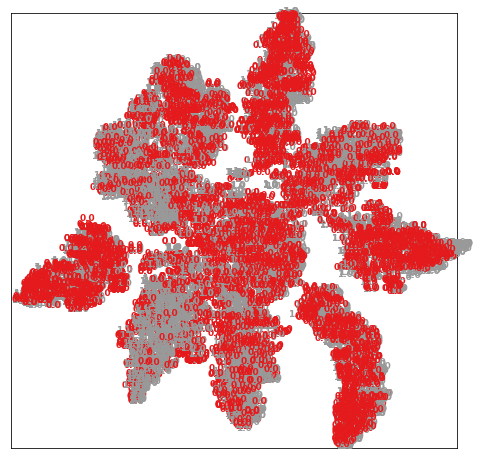

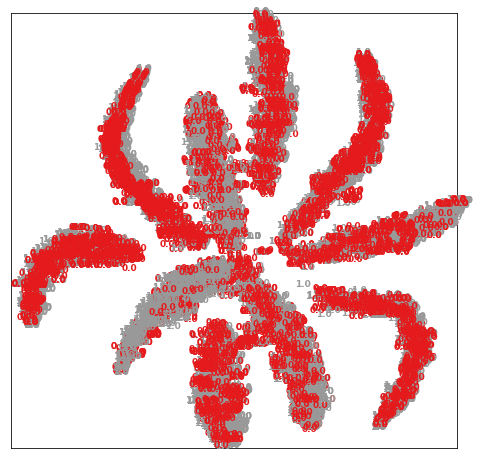

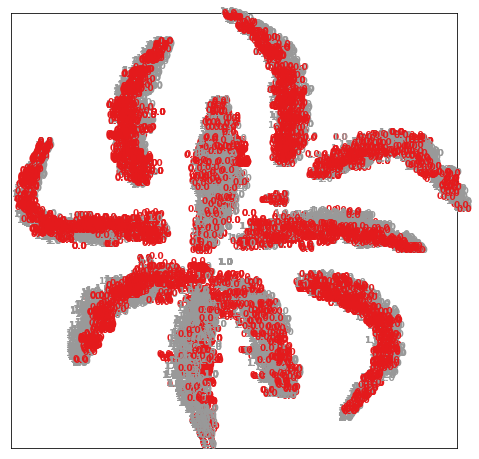

In [58]:
epochs = [100, 500, 900]
for epoch in epochs:
  source_dataloader = DataLoader(source_dataset, batch_size=100, shuffle=False)
  target_dataloader = DataLoader(target_dataset, batch_size=100, shuffle=False)
  feature_extractor.load_state_dict(torch.load(f'extractor_model_{epoch}.bin'))
  # domain_classifier.load_state_dict(torch.load(f'domain_classifier_{epoch}.bin'))
  feature_extractor.eval()
  X = None
  Y = None
  for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):
      source_data = source_data.cuda()
      source_label = source_label.cuda()
      target_data = target_data.cuda()
      mixed_data = torch.cat([source_data, target_data], dim=0)
      domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
      domain_label[:source_data.shape[0]] = 1
      with torch.no_grad():
        feature = feature_extractor(mixed_data)
      # if X == None:
      #   X = feature[:source_data.shape[0]].to('cpu')
      #   Y = source_label.to('cpu')
      # else:
      #   X = torch.cat([X, feature[:source_data.shape[0]].to('cpu')], dim=0)
      #   Y = torch.cat([Y, source_label.to('cpu')], dim=0)
      if X == None:
        X = feature.to('cpu')
        Y = domain_label.to('cpu')
      else:
        X = torch.cat([X, feature.to('cpu')], dim=0)
        Y = torch.cat([Y, domain_label.to('cpu')], dim=0)
      if i == 49:
        break
  X_tsne = manifold.TSNE(n_components=2, init='random', random_state=0, verbose=1).fit_transform(X)

  # Normalization the processed features 
  x_min, x_max = X_tsne.min(0), X_tsne.max(0)
  X_norm = (X_tsne - x_min) / (x_max - x_min)
  plt.figure(figsize=(8, 8))
  for i in range(X_norm.shape[0]):
      plt.text(X_norm[i, 0], X_norm[i, 1], str(Y[i].item()), color=plt.cm.Set1(Y[i].item()), fontdict={'weight': 'bold', 'size': 9})
  plt.xticks([])
  plt.yticks([])
  # plt.show()
  plt.savefig(f'q2_{epoch}.png')

## Step2: Apply t-SNE and normalize

In [30]:
# process extracted features with t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4832 samples in 0.003s...
[t-SNE] Computed neighbors for 4832 samples in 0.674s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4832
[t-SNE] Computed conditional probabilities for sample 2000 / 4832
[t-SNE] Computed conditional probabilities for sample 3000 / 4832
[t-SNE] Computed conditional probabilities for sample 4000 / 4832
[t-SNE] Computed conditional probabilities for sample 4832 / 4832
[t-SNE] Mean sigma: 0.606074
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.652077
[t-SNE] KL divergence after 1000 iterations: 0.843005


## Step3: Visualization with matplotlib

In [ ]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)



# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08901058@ntu.edu.tw / mlta-2022-spring@googlegroups.com。

